# 06_EventTimeScaleGrowth

Pease model of polynya growth

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_nsidc.icedrift as icedrift
import data_unibremen.SIC as unisic

sys.path.append('../')
import functions as fn

plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


In [2]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [3]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qld(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_strd_{event_year}_v7.nc') as ds_sw:
            down_longwave = ds_sw.strd.sel(time=event_df.time.values).values * units('W/m2')

        qld = (down_longwave) # longwave down

        return qld
    
    
    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.1)*(down_shortwave) # short wave radiation absorbed (10% albedo)

        return qr
    
    
    
    # wind component that extends polynya
#     wind_angle = (poly_dir+ta)*units('degree')
#     wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
#     wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')


    
    # observed wind speed and direction
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')
    wind_dir = vectors.vector_angle(event_df['u10'].values, event_df['v10'].values)
    
    # predicted ice speed and direction
    ice_speed = wf * wind_speed.to('km/day')
    ice_dir = wind_dir - (ta*units('degree'))
    
    # back to components
    ice_u = ice_speed * np.cos(ice_dir.to('radian').magnitude)
    ice_v = ice_speed * np.sin(ice_dir.to('radian').magnitude)
    
    # component of ice drift along polynya direction
    ice_comp_along_polynya = vectors.comp_along_theta(ice_u, ice_v, poly_dir*units('degree'))
    Vi = ice_comp_along_polynya
    
    # daily ice drift
#     Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
#     Qld = -open_Qld(event_df)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (10% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')
    
    
    # https://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node3.html
    # forward Euler (explicit)
    Xnp1 = Xn + dt * (Vn - Xn * Fn / H)
    # backward Euler (implicit)
    Xnp1 = Xn + dt * (Vnp1 - Xnp1 * Fnp1 / H)
    # solve for Xnp1
    Xnp1 = (Xn + (dt * Vnp1)) / (1 + dt * Fnp1 / H)
    
    

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)
        
        # current length (@ tn)
        X_n = Xp[-1]
        V_np1 = V[]
        
        
        (X_n + (dt * Vnp1)) / (1 + dt * Fnp1 / H)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    
    # if negative ice production (net heat uptake by ocean)
    # limiting case cannot be solved for
    if Fi < 0 * units('cm/day'):
        Fi = 0 * units('cm/day')
        X_max = [np.nan] * units('km')
        t95 = [np.nan] * units('day')
    
    
    
    
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip, Ta, Vi, wind_speed, event_df['u10'].values, Fi

SyntaxError: invalid syntax (3912436479.py, line 157)

In [27]:

    
def convert_to_k(T):

    if T.units == 'degree_Celsius':
        T = T.to('degree_Kelvin')
    elif T.units == 'delta_degree_Celsius':
        print('T!! should not be delta deg C')
    return T


def find_Qlu(Tw, sigma, eo):
    Tw = convert_to_k(Tw)
    qlu = sigma * eo * Tw**4
    return qlu.to('W/m2')


def find_Qld(Ta, sigma, ea):
    Ta = convert_to_k(Ta)
    qld = sigma * ea * Ta**4
    return qld.to('W/m2')


def find_Qs(Ta, Tw, rho_a, Cpa, Va):

    Ta = Ta.magnitude * units('delta_degree_Celsius')
    Tw = Tw.magnitude * units('delta_degree_Celsius')

    Ch = 2e-3 # sensible heat coefficient

    qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

    return qs.to('W/m2')


def open_Qld_bytime(times):
    
    
    all_ds = []
    
    # open all files
    for event_year in np.arange(2003, 2026):
        with xr.open_dataset(f'../data/forcing/regional_daily_era_strd_{event_year}_v7.nc') as ds:
            all_ds.append(ds)
            
    ds_lw = xr.concat(all_ds, 'time')
    
    # longwave down
    qld = ds_lw.strd.sel(time=times).values * units('W/m2')
    
    return qld


def open_Qr_bytime(times):
    
    all_ds = []
    
    # open all files
    for event_year in np.arange(2003, 2026):
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds:
            all_ds.append(ds)

    ds_sw = xr.concat(all_ds, 'time')
            
    down_shortwave = ds_sw.ssrd.sel(time=times).values * units('W/m2')
    qr = (1-0.1)*(down_shortwave)        
            
    return qr    
    
def surface_heat_balance(times, wind_speed, Ta, Tw = -1.8*units('degC')):
    
    """ numerical and analytical solutions to Pease model
    
    times: time
    wind_speed: wind speed (m/s)
    Ta: air temp (degC)
    Tw: water temp (degC), presumed -1.8*units('degC')
    
    """
    
    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
#     Qld = -open_Qld_bytime(times)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr_bytime(times) # short wave radiation absorbed (10% albedo)

    Qnet = Qlu+Qld+Qs+Qr
    
    return Qnet, Qlu, Qld, Qs, Qr
    
    

def Pease_Model_v3(Vi, Fi, Hi):
    
    """ numerical and analytical solutions to Pease model
    Vi: wind-driven ice drift along polynya orientation
    Hi : prescribed frazil ice collection thickness          
    
    """
    
    # ----------- solve for limiting width in Pease model -----------
    X_lim = (Vi * Hi / Fi).to('km')
    
    # ----------- time to reach 95% of limiting size -----------
    t95 = (3 * Hi / Fi).to('day')
    
    
    
    #  ----------- numerical solution --------------
    # https://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node3.html
    # forward Euler (explicit)
    # Xnp1 = Xn + dt * (Vn - Xn * Fn / H)
    
    # ----------- we will use backward Euler (implicit, more stable) --------------
    # Xnp1 = Xn + dt * (Vnp1 - Xnp1 * Fnp1 / H)
    # solve for Xnp1:
    # Xnp1 = (Xn + (dt * Vnp1)) / (1 + dt * Fnp1 / H)
    
    # array to store numerical polynya lengths
    X = np.array([])
    dt = units('day').to('s')
    
    # for ease in iterating thru timeseries
    # ii = (n+1)
    # ii-1 = (n)
    
    # begin from (ii = 0)
    # assuming polynya was closed prior to event start
    for ii in np.arange(0, len(Vi)):
    
        # polynya was closed previous
        # to start of opening events
        if ii == 0:
            Xn = 0 * units('km')
        else:
            Xn = X[ii-1]
            
        Vnp1 = Vi[ii]
        Fnp1 = Fi[ii]
        
        # solve for length of polynya now
        Xnp1 = (Xn + (dt * Vnp1)) / (1 + dt * Fnp1 / Hi)
        X = np.append(X, Xnp1)

        
    X_num = X
    
    return X_num, X_lim, t95


    

### Open compiled stats

In [5]:
df = pd.read_csv('../data/compiled_stats.csv')

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    angles = 90-df[f'{cat}']
    angles[angles<0]+=360
    df[f'{cat}_r'] = angles
    

# identify base period
dfb = df[df['2003_2023']]
dfr = df[df.year >= 2003]
    
# select time period to analyze
#================
DF = dfr
#================


#------------- identify strong east wind events -------------
def dir_conds(dff, cat):
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
    elif cat == 'ice':
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 11.5)
    return speed_cond

DF['east_wind_event'] = dir_conds(DF, 'wind')
DF['strong_wind_event'] = speed_conds(DF, 'wind')
DF['strong_east_wind_event'] = dir_conds(DF, 'wind') & speed_conds(DF, 'wind')
DF['no_req'] = DF.year>0


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/2462938731.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['east_wind_event'] = dir_conds(DF, 'wind')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/2462938731.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['strong_wind_event'] = speed_conds(DF, 'wind')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/2462938731.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

### Estimate ice growth from surface heat balance
### and rate of wind-driven ice drift along polynya orientation 

In [35]:
# model params
#===============================
wf = 0.03                       # ice:wind speed ratio
ta = 20 * units('degree')       # CW turning angle wind to ice, degrees
poly_dir = 145 *units('degree') # polynya direction, degrees CCW from E
Hi = 20 * units('cm')           # frazil ice collection thickness
#===============================


#------------- solve for the surface heat balance -------------
# this applies only to surface heat balance that *would* occur
# if ocean surface of -1.8 degC were exposed
Q = surface_heat_balance(pd.to_datetime(dfr.time.values), 
                     dfr.s10.values * units('m/s'),
                     dfr.t2m.values * units('degC'), 
                     Tw = -1.8*units('degC'))
Qnet, Qlu, Qld, Qs, Qr = Q

#------------- heat flux to ice production rate -------------
# EXPLICITLY SET NEGATIVE ICE GROWTH TO ZERO
# will not explicitly treat ice melt. Largest estimate melt rates of 5 cm/day
# would have no visible impact on melting the pack ice, which can be O(2-20m) thick
Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
Fi[Fi < 0*units('cm/day')] = 0 * units('cm/day')


#------------- estimate rate of wind-driven ice drift along polynya orientation -------------
# ------------------- grab wind data -------------------
# observed wind speed and direction
Ua = DF.u10.values * units('m/s')
Va = DF.v10.values * units('m/s')
wind_speed = np.sqrt(Ua**2 + Va**2)
wind_dir = vectors.vector_angle(Ua, Va)

# ------------------- estimate wind-drive ice drift -------------------
# predicted ice speed and direction
ice_speed = wf * wind_speed.to('km/day')
ice_dir = wind_dir - (ta)

# back to components
ice_u = ice_speed * np.cos(ice_dir.to('radian').magnitude)
ice_v = ice_speed * np.sin(ice_dir.to('radian').magnitude)

# component of ice drift along polynya direction
ice_comp_along_polynya = vectors.comp_along_theta(ice_u, ice_v, poly_dir)
Vi = ice_comp_along_polynya
    

DF['Qnet'] = Qnet
DF['Qlu'] = Qlu
DF['Qld'] = Qld
DF['Qln'] = Qlu + Qld
DF['Qs'] = Qs
DF['Qr'] = Qr
DF['Fi'] = Fi
DF['Vi'] = Vi

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/1670300544.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Qnet'] = Qnet
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/1670300544.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Qlu'] = Qlu
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/1670300544.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### Compare heat fluxes during Jan 2018 

Looking at ERA5 data I now recall why I avoided using it (and will make a note so I remember in future!). The polynyas are not well reproduced in the coarse ERA5 grid. SIC remains high (70%) where open waters are actually observed, yielding skin (snow surface) temperatures 20-30 degC below freezing  (within ~1 degC of the air temperature). This drastically reduces sensible heat fluxes compared to assuming the surface (skin) temperature is -1.8 degC, as would be expected in the polynya. This reduced net surface heat flux estimates from 500 W/m2 to 150 W/m2.


In [278]:
ds_list = []

variable_names = ['surface_latent_heat_flux_stream-oper_', 'surface_sensible_heat_flux_0_', 
                  'surface_net_solar_radiation_0_', 'surface_net_thermal_radiation_0_',
                 'sea_ice_cover_0_', 'sea_surface_temperature_stream-oper_',
                 'skin_temperature_0_', '2m_temperature_stream-oper_', 
                  'ice_temperature_layer_1_0_', 'ice_temperature_layer_4_0_',
                 'temperature_of_snow_layer_0_']

for var_name in variable_names:
    with xr.open_dataset(f'../data/era5_jan2018test/{var_name}daily-mean.nc') as ds:
        ds_list.append(ds)

ds = xr.merge(ds_list)

In [279]:
date = datetime(2018,1,9)

In [280]:
RES = '6250'
crop=[750, 950, 200, 400]
sic_key = 'sic'

dsic = unisic.open_local_file(date, res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

dsic['lon'][dsic['lon']>180] -=360


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_88344/228790774.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs[0].pcolormesh(dsic['lon'], dsic['lat'], dsic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)


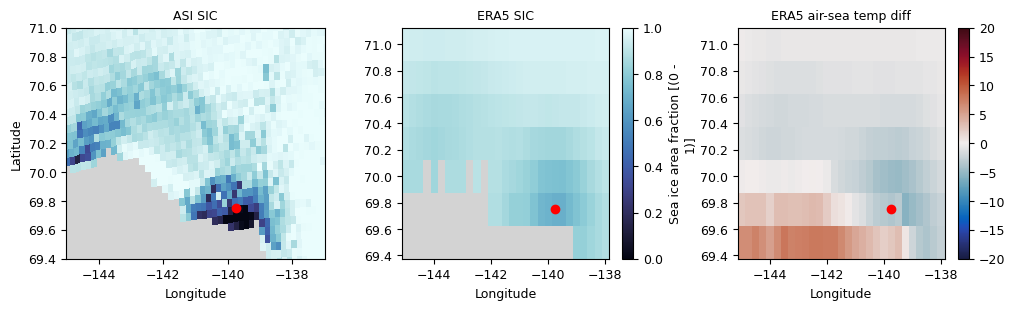

In [283]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
for ax in axs:
    ax.patch.set_facecolor('lightgray')
    ax.set_xlim(-145,-137)
    ax.set_ylim(69.4,71)
    ax.scatter( -139.75, 69.75, c='r', zorder=100)
    
    
ds.siconc.sel(valid_time = date).plot(ax = axs[1], vmin=0, vmax=1, cmap=cmocean.cm.ice)
axs[1].set_title('ERA5 SIC')
axs[1].set_ylabel('')
axs[1].set_xlabel('Longitude')

(ds.t2m-ds.tsn).sel(valid_time = date).plot(ax = axs[2], vmin=-20, vmax=20, cmap=cmocean.cm.balance)
# (ds.t2m-273.15).sel(valid_time = date).plot(ax = axs[2], vmin=-35, vmax=-20, cmap=cmocean.cm.thermal)
axs[2].set_title('ERA5 air-sea temp diff')
axs[2].set_ylabel('')
axs[2].set_xlabel('Longitude')

axs[0].pcolormesh(dsic['lon'], dsic['lat'], dsic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)
axs[0].set_title('ASI SIC')
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Longitude')

plt.subplots_adjust(wspace=0.3)

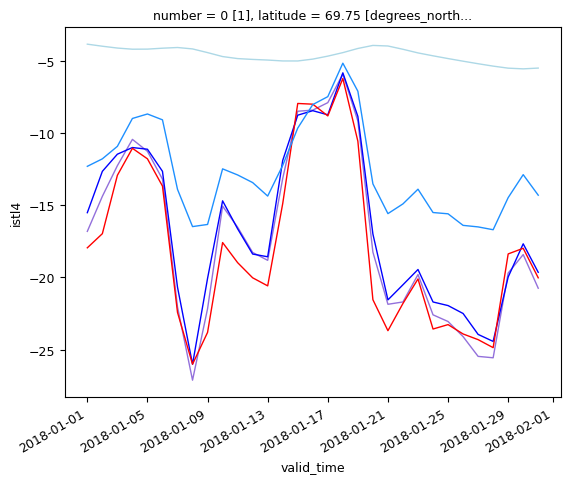

In [284]:
ds_loc = ds.sel(latitude = 69.75, longitude = -139.75)

time_cond = (DF.year==2018) & (DF.month==1)
(ds_loc['skt']-273.15).plot(c='mediumpurple')
(ds_loc['tsn']-273.15).plot(c='b')
(ds_loc['t2m']-273.15).plot(c='r')
(ds_loc['istl1']-273.15).plot(c='dodgerblue')
(ds_loc['istl4']-273.15).plot(c='lightblue')


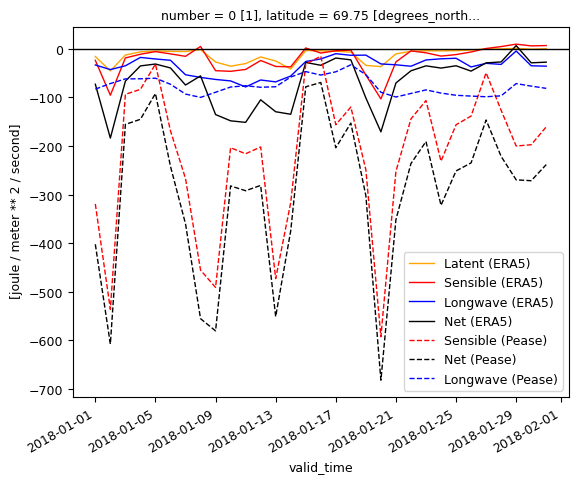

In [287]:
ds_loc = ds.sel(latitude = 69.75, longitude = -139.75)

net_rad = ds_loc['slhf'] + ds_loc['sshf'] + ds_loc['ssr'] + ds_loc['str']

main_units = units('J m-2')
accum_period = 1*units('hour').to('sec')# 60*60

(ds_loc['slhf']*main_units/accum_period).plot(c='orange', label='Latent (ERA5)')
(ds_loc['sshf']*main_units/accum_period).plot(c='r', label='Sensible (ERA5)')
# (ds_loc['ssr']*main_units/accum_period).plot(c='gray')
(ds_loc['str']*main_units/accum_period).plot(c='b', label='Longwave (ERA5)')
(net_rad*main_units/accum_period).plot(c='k', label='Net (ERA5)')

plt.axhline(0, c='k')

time_cond = (DF.year==2018) & (DF.month==1)
plt.plot(pd.to_datetime(DF.time.values[time_cond]), -DF.Qs[time_cond], c='r', ls='dashed', label='Sensible (Pease)')
plt.plot(pd.to_datetime(DF.time.values[time_cond]), -DF.Qnet[time_cond], c='k', ls='dashed', label='Net (Pease)')
plt.plot(pd.to_datetime(DF.time.values[time_cond]), -DF.Qln[time_cond], c='b', ls='dashed', label='Longwave (Pease)')

plt.legend()

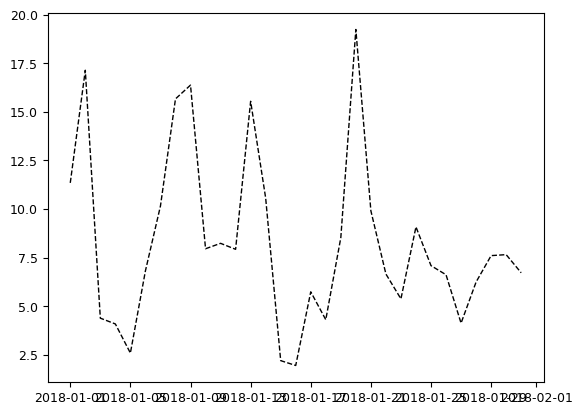

In [289]:
time_cond = (DF.year==2018) & (DF.month==1)
plt.plot(pd.to_datetime(DF.time.values[time_cond]), DF.Fi[time_cond], c='k', ls='dashed', label='Net (Pease)')

### Apply Pease model

In [7]:
seqs = np.array(list(set(DF.sequence[DF.sequence!=-999])))

df['cum_drift'] = 0
df['cum_drift_early'] = 0
df['X_Pease_limiting'] = 0
df['X_Pease_numerical'] = 0
df['Pease_t95'] = 0

for ss in seqs:
    
    # -----------  cumulative drift over course of event ---------------------
    first = DF[(DF.sequence == ss)].index[0]
    try:
        day_before = DF.loc[first-1].Vi
    except:
        day_before = 0
    DF.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(DF.loc[DF.sequence == ss, 'Vi']).values
    DF.loc[df.sequence == ss, 'cum_drift_early'] = np.cumsum(DF.loc[DF.sequence == ss, 'Vi']).values + day_before
    
    # -----------  apply Pease model ---------------------
    vi = DF.Vi[DF.sequence==ss].values * units('km/day')
    fi = DF.Fi[DF.sequence==ss].values * units('cm/day')
    X_num, X_lim, t95 = Pease_Model_v3(vi, fi, Hi)
    
    DF.loc[df.sequence == ss, 'X_Pease_limiting'] = X_lim.magnitude
    DF.loc[df.sequence == ss, 'X_Pease_numerical'] = X_num.magnitude
    DF.loc[df.sequence == ss, 'Pease_t95'] = t95.magnitude
    
    

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_6158/946153787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(DF.loc[DF.sequence == ss, 'Vi']).values
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_6158/946153787.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF.loc[df.sequence == ss, 'cum_drift_early'] = np.cumsum(DF.loc[DF.sequence == ss, 'Vi']).values + day_before
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykerne

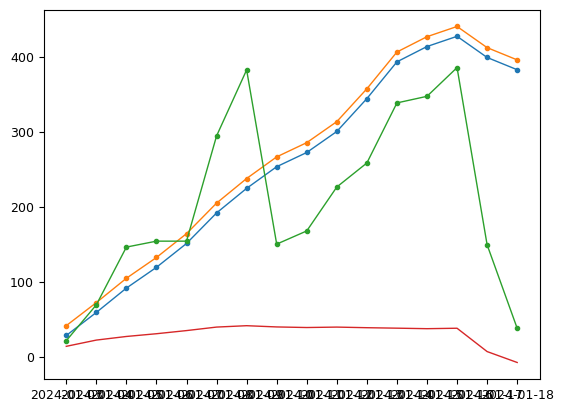

In [8]:
ss = 150

# plt.plot(DF.time[DF.sequence == SS], np.cumsum(DF.Vi[DF.sequence == SS]), marker='.')
plt.plot(DF.time[DF.sequence == ss], DF.cum_drift[DF.sequence == ss], marker='.')
plt.plot(DF.time[DF.sequence == ss], DF.cum_drift_early[DF.sequence == ss], marker='.')
plt.plot(DF.time[DF.sequence == ss], DF.length_145max[DF.sequence == ss], marker='.')

plt.plot(DF.time[DF.sequence == ss], DF.X_Pease_numerical[DF.sequence == ss])

In [9]:

#=====================================
# category = "no_req"
# category = "east_wind_event"
# category = "strong_wind_event"
category = "strong_east_wind_event"
#=====================================

east_maint = np.copy(DF[category])
print(np.sum(east_maint))

for ss in list(set(DF.sequence[DF.sequence!=-999])):
    
    # sequence index start
    II = np.where(DF.sequence.values==ss)[0][0]
    FF = np.where(DF.sequence.values==ss)[0][-1]
    
    not_east = (DF[category][DF.sequence==ss].values) == False

    # if a not-east event is found
    if len(np.where(not_east)[0]) > 0:
        # everywhere after first not-east event (up to end of event) is false
        east_maint[II+np.where(not_east)[0][0]:FF+1] = False
    
    
DF['east_maintained'] = east_maint

646


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_6158/4029053775.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['east_maintained'] = east_maint


(array([97., 69., 59., 31., 12.,  6.,  3.,  2.,  1.,  5.]),
 array([ 10.84761507,  19.8570956 ,  28.86657614,  37.87605667,
         46.88553721,  55.89501774,  64.90449827,  73.91397881,
         82.92345934,  91.93293988, 100.94242041]),
 <BarContainer object of 10 artists>)

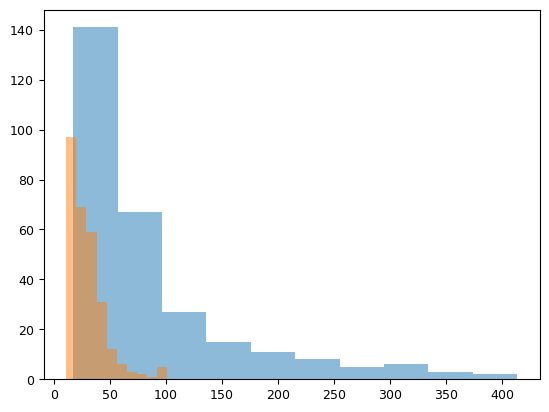

In [10]:
plt.hist(DF.cum_drift[(DF.extent>0)&(DF.east_maintained)], alpha=0.5)
plt.hist(DF.X_Pease_numerical[(DF.extent>0)&(DF.east_maintained)], alpha=0.5)
# plt.hist(DF.X_Pease_limiting[(DF.extent>0)&(DF.east_maintained)], alpha=0.5)

In [11]:


# specify event length
#=============
L = 13
#=============

print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

# specify which days allowed to include
#=============
no_shoulder = (DF['season_start_flag']==False)#&(DF['season_end_flag']==False)
event_cond = (DF.extent>0)&(no_shoulder & (DF['east_maintained']))
#=============


# comp_ = (DF.extent==0)
# comp_[(DF.day_before_event>=-3)]=False
# comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False


# days before events
days_before = np.array([-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [((DF['day_before_event'] == dd)&(DF['before_event_length']>=1))&(DF['season_start_flag']==False) for dd in days_before]

# days during events up to length L
days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(event_cond)) for dd in days_during]

# all days longer than event length L
days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L))&(event_cond)]

# all final days of events
day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(DF['season_start_flag']==False))]   

# days after events
days_after = np.array([1,2])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [((DF['day_after_event'] == dd)&(DF['after_event_length']>=1))&(DF['season_start_flag']==False)for dd in days_after]   


# x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
# x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
# all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))

# x_values = np.concatenate((1+days_before, days_during, days_more, 1+L+days_after))
# x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_after))
# all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_after))

# x_values = np.concatenate((days_during, days_more))
# x_labels = np.concatenate((labels_during, labels_more))
# all_cond = np.concatenate((conds_during, conds_more))


x_values = days_during 
x_labels = labels_during
all_cond = conds_during


across = {}
for dd, cond in zip(x_labels, all_cond):

    across[dd] = {}
    across[dd]['date'] = DF.time[cond].values


3
160


In [12]:

cats = ['X_Pease_numerical', 'cum_drift', 'length_145max']


percents = [5,10,25,50,75,90,95]
also = ['avg', 'std', 'avg_ms', 'avg_ps']


timedata = {}

for cat in cats:
    
    timedata[cat] = {}
    
    for per in percents:
        timedata[cat][per] = np.array([])
    for per in also:
        timedata[cat][per] = np.array([])


    for dd, cond in zip(x_values, all_cond):
        for per in percents:
            timedata[cat][per] = np.append(timedata[cat][per], np.nanpercentile(DF[cat][cond], per))
        timedata[cat]['avg'] = np.append(timedata[cat]['avg'], np.nanmean(DF[cat][cond]))
        timedata[cat]['std'] = np.append(timedata[cat]['std'], np.nanstd(DF[cat][cond]))

        timedata[cat]['avg_ms'] = np.append(timedata[cat]['avg_ms'], np.nanmean(DF[cat][cond]) - np.nanstd(DF[cat][cond]))
        timedata[cat]['avg_ps'] = np.append(timedata[cat]['avg_ps'], np.nanmean(DF[cat][cond]) + np.nanstd(DF[cat][cond]))
    
    
#

timedata['num_days'] = np.array([])
for dd, cond in zip(x_values, all_cond):
    timedata['num_days'] = np.append(timedata['num_days'], np.sum(cond))

length_145max


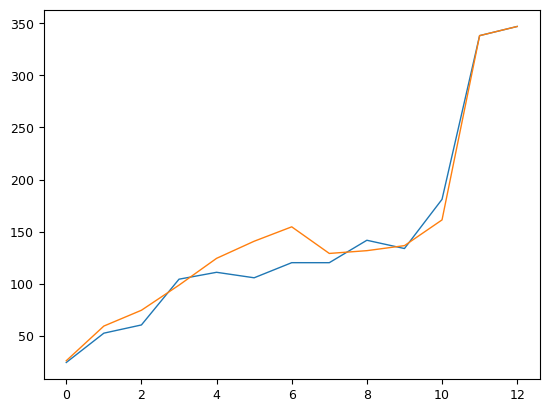

In [13]:
print(cat)

plt.plot(timedata[cat][50])
plt.plot(timedata[cat]['avg'])

In [14]:
lighter_red = (
    (int(255 + 0.35 * (255 - 255))/255),  # R stays the same
    (int(0   + 0.35 * (255 - 0))/255),    # G
    (int(0   + 0.35 * (255 - 0))/255  )   # B
)
lighter_dodgerblue = (
    (int(30 + 0.25 * (255 - 30))/255),    # R
    (int(144 + 0.25 * (255 - 144))/255),  # G
    (int(255 + 0.25 * (255 - 255))/255)   # B
)


LinregressResult(slope=0.8012612202094932, intercept=31.296786922407662, rvalue=0.677969787945225, pvalue=6.661487640115359e-39, stderr=0.05219925155517943, intercept_stderr=4.900969596843881)
LinregressResult(slope=0.14190048558693397, intercept=19.705792426034044, rvalue=0.5844681768768352, pvalue=5.904167287269863e-27, stderr=0.01183660166617994, intercept_stderr=1.1113344189346606)


<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_6158/1583205388.py:57: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


Text(0.5, 1.025, 'Latent heat')

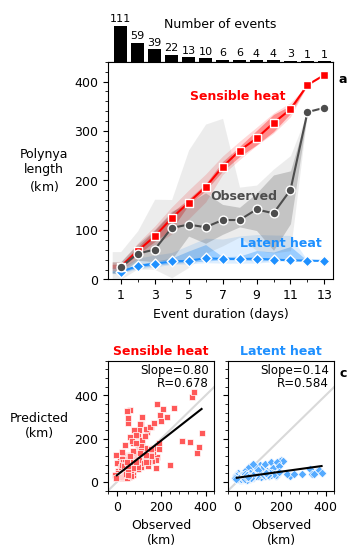

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec


lo = 0

fig = plt.figure(figsize=(3, 6.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 0.35], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2_left = fig.add_subplot(gs[2, 0])
ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.425+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.425, 0.75, 0.335]) 
ax2_left.set_position([0.1, 0.1, 0.355, 0.2]) 
ax2_right.set_position([0.5, 0.1, 0.355, 0.2]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = 'k'# [0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.6,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(20))


# Text labels
ax1.text(0.575, 0.825, 'Sensible heat',weight='bold',  ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.755, 0.365, 'Observed', weight='bold', ha='right', c=[0.3]*3, transform=ax1.transAxes)
ax1.text(0.95, 0.15, 'Latent heat',weight='bold',  ha='right', c='dodgerblue', transform=ax1.transAxes)


bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    ['X_Pease_numerical', 'cum_drift', 'length_145max'],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, timedata[category][50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, timedata[category][50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([timedata[category][low][0]], timedata[category][low], [timedata[category][low][-1]]))
        Y2_exp = np.concatenate(([timedata[category][high][0]], timedata[category][high], [timedata[category][high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
# xxx = 1.5
# ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
# for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
#     ax1.fill_between(np.linspace(xxx - 0.35, xxx + 0.35, 3), 
#                      np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
# color = [0.65]*3
# for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
#     ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)

    
# --- Bottom Two Side-by-Side Subplots ---
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)

ax2_left.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_left.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.xaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.xaxis.set_minor_locator(ticker.MultipleLocator(40))

# Left plot: cum_drift vs length_145max
COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['cum_drift'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

for ax in [ax2_left, ax2_right]:
    ax.set_xlim(-40, 440)
    ax.set_ylim(-40, 560)
    ax.plot([-50,500],[-50,500], c=[0.85]*3,lw=1.5,  zorder=-1)

ax2_left.scatter(x, y, s=20, facecolor=lighter_red, alpha=1, marker='s', lw=0.5, edgecolor='w')

ax2_left.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='k', lw=1.5, ls='solid')
ax2_left.set_xlabel('Observed\n(km)')
ax2_left.set_ylabel('Predicted\n(km)', rotation=0, labelpad=25, va='center')

ax2_left.text(0.95,0.975, f'Slope={resp.slope:.2f}',
              size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_left.transAxes)
ax2_left.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
              size = plt.rcParams['font.size']-0.5, ha='right', va='top',  transform = ax2_left.transAxes)




# Right plot: X_Pease vs length_145max
COND = (event_cond)# & ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['X_Pease_numerical'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax2_right.scatter(x,y, s=20, facecolor=lighter_dodgerblue, alpha=1, marker='D', lw=0.5, edgecolor='w')
ax2_right.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='k', lw=1.5, ls='solid')
ax2_right.set_xlabel('Observed\n(km)')
ax2_right.tick_params(labelleft=False)

ax2_right.text(0.95,0.975, f'Slope={resp.slope:.2f}',
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)
ax2_right.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)



# ax2_right.set_xlim(0,100)



for label, ax, offset in zip(['a','c'],[ax1, ax2_right], [0,0.025]):
    ax.text(1.025+offset, 0.95, label, ha='left', va='top', weight='bold', transform=ax.transAxes)
    
# offset = [0,0.025]
# for i, ax in enumerate([ax1, ax2_right]):
#     ax.text(1.025+offset[i], 0.95, f'{chr(97 + i)}', ha='left', va='top', weight='bold', transform=ax.transAxes)

ax2_left.text(0.5,1.025, 'Sensible heat', weight='bold', color='r', ha='center', va='bottom', transform=ax2_left.transAxes)
ax2_right.text(0.5,1.025, 'Latent heat', weight='bold', color='dodgerblue', ha='center', va='bottom', transform=ax2_right.transAxes)
    

# fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')


<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_6158/1500878597.py:57: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


LinregressResult(slope=0.8012612202094932, intercept=31.296786922407662, rvalue=0.677969787945225, pvalue=6.661487640115359e-39, stderr=0.05219925155517943, intercept_stderr=4.900969596843881)
LinregressResult(slope=0.14190048558693397, intercept=19.705792426034044, rvalue=0.5844681768768352, pvalue=5.904167287269863e-27, stderr=0.01183660166617994, intercept_stderr=1.1113344189346606)


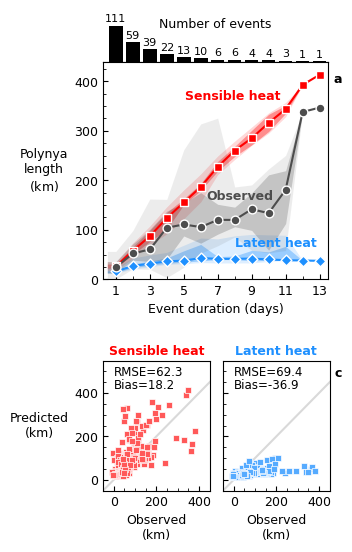

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec


lo = 0

fig = plt.figure(figsize=(3, 6.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 0.35], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2_left = fig.add_subplot(gs[2, 0])
ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.425+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.425, 0.75, 0.335]) 
ax2_left.set_position([0.1, 0.1, 0.355, 0.2]) 
ax2_right.set_position([0.5, 0.1, 0.355, 0.2]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = 'k'# [0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.6,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(25))
ax1.tick_params(axis='y', which='both', direction='in')
ax1.tick_params(axis='x', which='both', direction='in')

# Text labels
ax1.text(0.575, 0.825, 'Sensible heat',weight='bold',  ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.755, 0.365, 'Observed', weight='bold', ha='right', c=[0.3]*3, transform=ax1.transAxes)
ax1.text(0.95, 0.15, 'Latent heat',weight='bold',  ha='right', c='dodgerblue', transform=ax1.transAxes)


bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    ['X_Pease_numerical', 'cum_drift', 'length_145max'],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, timedata[category][50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, timedata[category][50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([timedata[category][low][0]], timedata[category][low], [timedata[category][low][-1]]))
        Y2_exp = np.concatenate(([timedata[category][high][0]], timedata[category][high], [timedata[category][high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
# xxx = 1.5
# ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
# for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
#     ax1.fill_between(np.linspace(xxx - 0.35, xxx + 0.35, 3), 
#                      np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
# color = [0.65]*3
# for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
#     ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)

    
# --- Bottom Two Side-by-Side Subplots ---
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)

ax2_left.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.yaxis.set_minor_locator(ticker.MultipleLocator(50))

ax2_right.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.yaxis.set_minor_locator(ticker.MultipleLocator(50))

ax2_left.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.xaxis.set_minor_locator(ticker.MultipleLocator(50))

ax2_right.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.xaxis.set_minor_locator(ticker.MultipleLocator(50))


for ax, cat, color in zip([ax2_left, ax2_right], 
                          ['cum_drift', 'X_Pease_numerical'], 
                          [lighter_red, lighter_dodgerblue]):

    ax.set_xlim(-50, 450)
    ax.set_ylim(-50, 550)
    ax.plot([-50,500],[-50,500], c=[0.85]*3,lw=1.5,  zorder=-1)
    ax.set_xlabel('Observed\n(km)') 
    
    
    COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
    x = DF['length_145max'][COND].values
    y = DF[cat][COND].values
    mask = np.isfinite(x) & np.isfinite(y)
    resp = stats.linregress(x[mask], y[mask])
    print(resp)


    ax.scatter(x, y, s=20, facecolor=color, alpha=1, marker='s', lw=0.5, edgecolor='w')
    
    
#     ax.text(0.75,0.55, f'1:1', weight='normal',
#                   size = plt.rcParams['font.size']-0.5, c='lightgray', rotation=45,  transform = ax.transAxes)

    
    ax.text(0.1,0.86, f'Bias={np.nanmean(y-x):.1f}',
                  size = plt.rcParams['font.size']-0.5, ha='left', va='top',   transform = ax.transAxes)
    ax.text(0.1,0.96, f'RMSE={np.sqrt(np.nanmean((y-x)**2)):.1f}', 
                  size = plt.rcParams['font.size']-0.5, ha='left', va='top',  transform = ax.transAxes)


ax2_left.set_ylabel('Predicted\n(km)', rotation=0, labelpad=25, va='center')
ax2_right.tick_params(labelleft=False)



for label, ax, offset in zip(['a','c'],[ax1, ax2_right], [0,0.025]):
    ax.text(1.025+offset, 0.95, label, ha='left', va='top', weight='bold', transform=ax.transAxes)
    
# offset = [0,0.025]
# for i, ax in enumerate([ax1, ax2_right]):
#     ax.text(1.025+offset[i], 0.95, f'{chr(97 + i)}', ha='left', va='top', weight='bold', transform=ax.transAxes)

ax2_left.text(0.5,1.025, 'Sensible heat', weight='bold', color='r', ha='center', va='bottom', transform=ax2_left.transAxes)
ax2_right.text(0.5,1.025, 'Latent heat', weight='bold', color='dodgerblue', ha='center', va='bottom', transform=ax2_right.transAxes)
    
for ax in [ax2_left,ax2_right]:
    ax.tick_params(axis='y', which='both', direction='in')
    ax.tick_params(axis='x', which='both', direction='in')
    
fig.savefig('../figures/results/pease_model/timeseries_v2.png', dpi=400, bbox_inches='tight')


In [984]:
np.nanmedian(DF['length_145max'][event_cond&(DF.event_day<=4)])

37.01720826780848

In [989]:
np.nanmean((DF['length_145max']-DF['X_Pease_numerical'])[event_cond&(DF.event_day<=4)])

24.809535977174228

<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_2510/458034900.py:57: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


X_Pease_numerical
-36.90722105030844
69.43548176981585

cum_drift
18.185019546280465
62.25052633483976



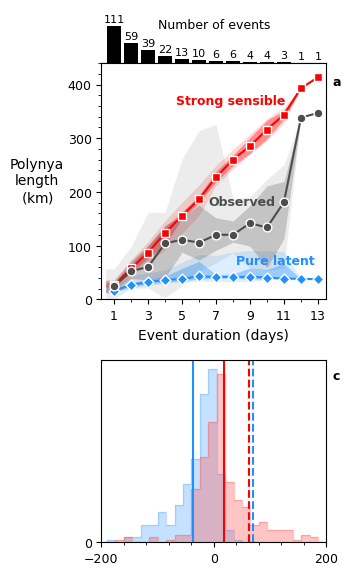

In [957]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec


lo = 0

fig = plt.figure(figsize=(3, 6.75))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 0.75], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.425+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.425+0.025-0.04, 0.75, 0.35]) 
ax2.set_position([0.1, 0.05, 0.75, 0.27]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = 'k'# [0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.6,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(20))


# Text labels
ax1.text(0.575, 0.825, 'Strong sensible',weight='bold',  ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.775, 0.4, 'Observed', weight='bold', ha='right', c=[0.3]*3, transform=ax1.transAxes)
ax1.text(0.95, 0.15, 'Pure latent', weight='bold', ha='right', c='dodgerblue', transform=ax1.transAxes)


bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    ['X_Pease_numerical', 'cum_drift', 'length_145max'],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, timedata[category][50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, timedata[category][50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([timedata[category][low][0]], timedata[category][low], [timedata[category][low][-1]]))
        Y2_exp = np.concatenate(([timedata[category][high][0]], timedata[category][high], [timedata[category][high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
# xxx = 1.5
# ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
# for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
#     ax1.fill_between(np.linspace(xxx - 0.35, xxx + 0.35, 3), 
#                      np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
# color = [0.65]*3
# for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
#     ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)

    
# --- Bottom Two Side-by-Side Subplots ---
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


ax = ax2

ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(40))
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(40))

ax.set_xlim(-200,200)
COND = (event_cond) #& (DF.event_day<4) #& ((DF.sequence!=119)&(DF.sequence!=150))

bins = np.arange(-400,400,15)


for cat, color, c2 in zip(['X_Pease_numerical', 'cum_drift'],
                      ['dodgerblue', 'r'], [lighter_dodgerblue, lighter_red]):

    x = DF['length_145max'][COND].values
    y = DF[cat][COND].values

    BIAS = np.nanmean((y-x))
    RMSE = np.sqrt(np.nanmean((y-x)**2))
    print(cat)
    print(BIAS)
    print(RMSE)
    print()

    hi = plotter.quick_hist(y-x, bin_edges=bins)
    
    ax.bar(hi['centers'], hi['prob'], width=hi['w'],  color=c2, alpha=0.35)
    ax.stairs(values= hi['prob'],edges = hi['edges'],   fill=False, color=c2, alpha=0.35)

    ax.axvline(BIAS, c=color, lw=1.5, )
    ax.axvline(RMSE, c=color, lw=1.5, ls='dashed')

# ax2_right.set_xlim(0,100)


for label, ax, offset in zip(['a','c'],[ax1, ax2], [0,0.025]):
    ax.text(1.025, 0.95, label, ha='left', va='top', weight='bold', transform=ax.transAxes)




fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')


X_Pease_numerical
-36.90722105030844
69.43548176981585

cum_drift
18.185019546280465
62.25052633483976



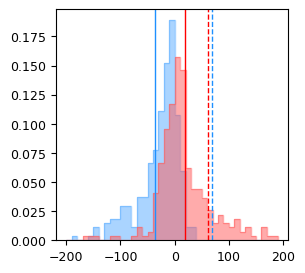

In [935]:
fig, ax = plt.subplots(figsize=(3,3))

COND = (event_cond) #& (DF.event_day<4) #& ((DF.sequence!=119)&(DF.sequence!=150))

bins = np.arange(-200,200,10)


for cat, color, c2 in zip(['X_Pease_numerical', 'cum_drift'],
                      ['dodgerblue', 'r'], [lighter_dodgerblue, lighter_red]):

    x = DF['length_145max'][COND].values
    y = DF[cat][COND].values

    BIAS = np.nanmean((y-x))
    RMSE = np.sqrt(np.nanmean((y-x)**2))
    print(cat)
    print(BIAS)
    print(RMSE)
    print()

    hi = plotter.quick_hist(y-x, bin_edges=bins)
    
    plt.bar(hi['centers'], hi['prob'], width=hi['w'],  color=c2, alpha=0.5)
    plt.stairs(values= hi['prob'],edges = hi['edges'],   fill=False, color=c2, alpha=0.5)

    plt.axvline(BIAS, c=color)
    plt.axvline(RMSE, c=color, ls='dashed')



In [864]:
across['12']

{'date': array(['2024-01-14'], dtype=object)}

In [865]:
COND = (event_cond) & ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['cum_drift'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

LinregressResult(slope=0.9744796235553497, intercept=22.81266690587971, rvalue=0.637097270881585, pvalue=5.219641002278431e-31, stderr=0.07339889539017422, intercept_stderr=5.280211796958784)


In [815]:
np.nansum(y - x > 0)/len(y)

0.6470588235294118

In [545]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'a10_r', 'ai_r', 'centermass_direction_r', 'max_length_direction_r',
       'east_wind_event', 'strong_wind_event', 'strong_east_wind_event',
       'Qnet', 'Fi', 'Vi', 'cum_drift', 'X_Pease_limiting',
       'X_Pease_numerical', 'Pease_t95', 'east_maintained', 'up', 'vp'],
      dtype='object')

In [579]:
np.nanpercentile(DF.extent.values[DF.extent.values>0], 90)

3537.374720126672

In [557]:
DF.time[DF.sequence==160]

5692    2025-03-06
5693    2025-03-07
5694    2025-03-08
5695    2025-03-09
5696    2025-03-10
5697    2025-03-11
5698    2025-03-12
5699    2025-03-13
5700    2025-03-14
5701    2025-03-15
Name: time, dtype: object

In [558]:
DF.extent[DF.sequence==160]

5692     233.774945
5693    2378.834786
5694    3433.856698
5695    5034.379765
5696    7107.489023
5697    7186.104723
5698    2653.850609
5699    1560.653911
5700    1169.532496
5701    1403.532816
Name: extent, dtype: float64

In [593]:
df.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'a10_r', 'ai_r', 'centermass_direction_r', 'max_length_direction_r',
       'cum_drift', 'X_Pease_limiting', 'X_Pease_numerical', 'Pease_t95'],
      dtype='object')

In [648]:
df.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'a10_r', 'ai_r', 'centermass_direction_r', 'max_length_direction_r',
       'cum_drift', 'X_Pease_limiting', 'X_Pease_numerical', 'Pease_t95'],
      dtype='object')

In [649]:
10.5*units('km/day').to('cm/s')

<Quantity(12.1527778, 'centimeter / second')>

LinregressResult(slope=0.5544401544401545, intercept=-1088.263063063063, rvalue=0.4499847577886742, pvalue=0.005893573498260681, stderr=0.18870634152590376, intercept_stderr=378.45564507374417)


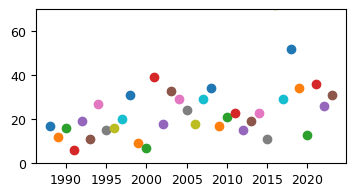

In [672]:
fig, ax = plt.subplots(figsize=(4,2))

ax.set_ylim(0,70)

x = np.arange(1988,2024)
y = np.array([])
for year in x:
    
    num_drift = np.sum(dir_conds(df[df.year==year], 'ice')& (df[df.year==year].si > 12.2))
    num_wind = np.sum(dir_conds(df[df.year==year], 'wind')& (df[df.year==year].s10 > 7))
    y = np.append(y,num_drift)
    ax.scatter(year,num_drift)
    
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

In [673]:
25*25

625

In [660]:
0.496875583**2

0.2468853449815899

(-40.0, 40.0)

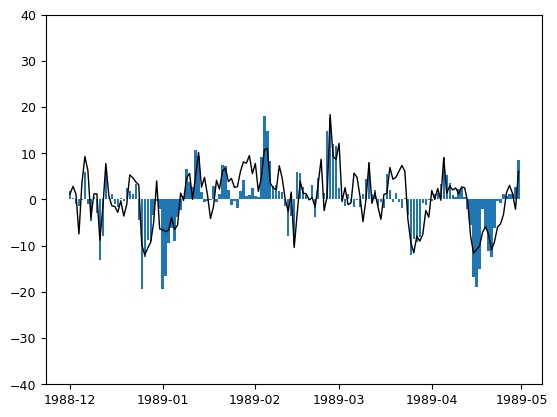

In [641]:
YR = 1989

plt.bar(pd.to_datetime(df.time[df.year==YR]), df.ui[df.year==YR])
# plt.scatter(pd.to_datetime(df.time[df.year==YR]), 10*(dir_conds(df[df.year==YR], 'wind')&speed_conds(df[df.year==YR], 'wind')).astype(float))
plt.plot(pd.to_datetime(df.time[df.year==YR]), df.u10[df.year==YR], c='k')
plt.ylim(-40,40)

# plt.axvline(datetime(1993,12,22), c='k')

In [701]:
np.nanpercentile(DF.extent[DF.extent>0],90)

3537.374720126672

In [702]:
list(set(DF[DF.extent>3537.374720126672].sequence))

[160, 33, 130, 99, 109, 14, 93, 119, 86, 87, 150, 157, 59, 61]

In [703]:
list(set(DF[DF.extent>3537.374720126672].year))

[2016, 2017, 2018, 2019, 2020, 2021, 2024, 2025, 2004, 2008, 2013, 2014]

In [ ]:
December 22, 1993

In [585]:
np.nanstd(DF.extent[DF.extent>0])

3083.617829344582

In [588]:
np.nanmean(DF.extent[DF.extent>0]) + np.nanstd(DF.extent[DF.extent>0])

4680.485717806363

In [695]:
np.sum(DF[DF.year>=2016].extent>0)/len(list(set(DF.year[DF.year>=2016])))

32.4

In [696]:
np.sum(DF[(DF.year<2016)&(DF.year!=2012)].extent>0)/len(list(set(DF.year[(DF.year<2016)&(DF.year!=2012)])))

16.75

In [700]:
np.sum(DF.extent[DF.sequence==150])

102928.22815121633

In [578]:
np.sum(DF[DF.year>=2016].extent>3537.374720126672) / np.sum(DF.extent>3537.374720126672)

0.7924528301886793

In [581]:
list(set(DF[(DF.year>=2016)&(DF.extent>3537.374720126672)].sequence))

[160, 130, 99, 109, 119, 86, 87, 150, 157, 93]

In [582]:
list(set(DF[(DF.year<2016)&(DF.extent>3537.374720126672)].sequence))

[33, 59, 61, 14]

In [555]:
np.sum(DF[DF.year==2016].extent>1000)

29

In [549]:
7.6/3.583

2.1211275467485344

In [546]:
32.4/16.75

1.9343283582089552

In [544]:
32.4/16.75

1.9343283582089552

In [541]:
7.6/3.58333333333

2.1209302325601125

In [537]:
list(set(DF.year[(DF.year<2016)&(DF.year!=2012)]))

[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015]

In [681]:
np.nanpercentile(DF.extent[DF.extent>0], 50)

545.7664861031562

In [685]:
max_extents = np.array([])

for ss in list(set(DF.sequence[DF.sequence!=-999])):
    
    max_extents = np.append(max_extents, DF.extent[DF.sequence==ss].max())

In [690]:
len(max_extents)#/len(np.arange(2004,2026))

162

In [693]:
np.sum(max_extents>625)/len(max_extents)

0.41975308641975306

In [694]:
max_extents

array([ 1014.96555216,   389.62591686,  1130.75371399,   662.66678062,
        2616.32250072,  1599.17311007,   311.80687403,    38.95457585,
         272.77344483,   350.91785285,   311.74290263,  3277.70896063,
          38.96608103,  4491.83162118,   818.85698728,   116.8957719 ,
        2379.31340979,  2379.89253625,   194.87289432,    77.97755809,
         389.81114911,    38.99560082,  2302.98910145,   155.90862983,
          77.93100359,   467.67773848,   194.82994895,   389.70543986,
        1559.8209529 ,   311.78053481,    38.98087537,  2613.4739118 ,
       18524.65724707,   428.8902327 ,   428.65788676,    38.96932502,
          77.93548319,    38.97032919,   624.40978157,   311.90680448,
        3355.94997417,  2340.67108851,   155.94032775,   155.86169866,
          38.97032919,   116.92060786,    38.98497138,   116.95194473,
         936.35673664,   858.05515403,  2106.22581846,   194.86729188,
          38.9976499 ,    77.94915763,   233.79587749,  1092.22839062,
      

In [684]:
np.sum((DF.extent>625))/np.sum((DF.extent>0))

0.46285714285714286

LinregressResult(slope=0.11544401544401545, intercept=-205.27297297297298, rvalue=0.11828292672093088, pvalue=0.4920391927400123, stderr=0.1662074078012314, intercept_stderr=333.3334281551704)


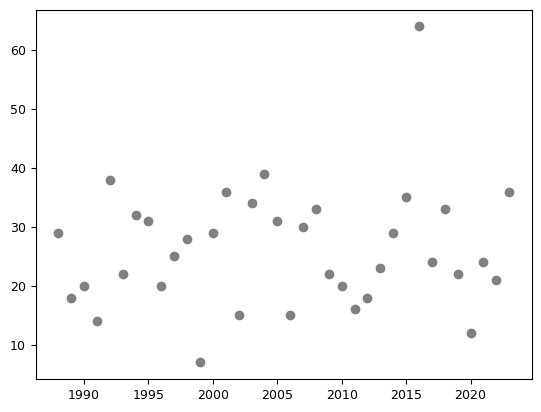

In [726]:
years = np.arange(1988,2024)
all_wind = np.array([])
all_years = np.array([])
all_ice = np.array([])

for year in years:

    num_east = np.sum(dir_conds(df[df.year==year],'wind')&speed_conds(df[df.year==year],'wind'))
    all_wind = np.append(all_wind,num_east)
    num_ice = np.sum(dir_conds(df[df.year==year],'ice')&(df[df.year==year].si>12))#&speed_conds(DF[DF.year==year],'wind'))
    all_ice = np.append(all_ice, num_ice)

plt.scatter(years, all_wind, c='gray')
# plt.scatter(years, all_ice, c='k')
    
    
x = years
y = all_wind
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)


In [522]:
np.nanmean((DF['length_145max'] - DF['X_Pease_numerical'])[COND&(DF.event_day<=4)])

24.809535977174228

In [496]:
# L20 = np.copy(DF['X_Pease_numerical'])
# L10 = np.copy(DF['X_Pease_numerical'])
np.nanmedian((L20/L10)[COND])

1.5568092601045345

In [513]:
np.sum((DF['length_145max'] - DF['cum_drift'])[COND] < 0)/np.sum(COND)

0.6379928315412187

In [462]:
0.584**2

0.45968400000000004

In [499]:
np.nanstd((DF['length_145max'] - DF['X_Pease_numerical'])[COND])

58.814480895015116

In [498]:
np.nanmean((DF['length_145max'] - DF['cum_drift'])[COND])

-18.185019546280465

In [464]:
np.nanmedian((DF['X_Pease_numerical'])[COND])

26.58942849762273

In [500]:
np.nanmedian((DF['X_Pease_numerical'])[COND])

26.58942849762273

In [501]:
np.sum((DF['X_Pease_numerical'])[COND]<50) / np.sum(COND)

0.9175627240143369

In [455]:
lighter_red = (
    (int(255 + 0.45 * (255 - 255))/255),  # R stays the same
    (int(0   + 0.45 * (255 - 0))/255),    # G
    (int(0   + 0.45 * (255 - 0))/255  )   # B
)
lighter_dodgerblue = (
    (int(30 + 0.35 * (255 - 30))/255),    # R
    (int(144 + 0.35 * (255 - 144))/255),  # G
    (int(255 + 0.35 * (255 - 255))/255)   # B
)


<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_2510/3900035252.py:57: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


LinregressResult(slope=0.8012612202094932, intercept=31.296786922407662, rvalue=0.677969787945225, pvalue=6.661487640115359e-39, stderr=0.05219925155517943, intercept_stderr=4.900969596843881)
LinregressResult(slope=0.14190048558693397, intercept=19.705792426034044, rvalue=0.5844681768768352, pvalue=5.904167287269863e-27, stderr=0.01183660166617994, intercept_stderr=1.1113344189346606)


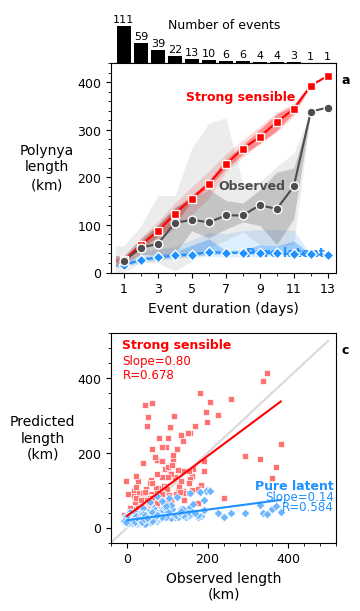

In [456]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec


lo = 0

fig = plt.figure(figsize=(3, 6.75))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 1], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.425+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.425+0.025, 0.75, 0.31]) 
ax2.set_position([0.1, 0.05, 0.75, 0.31]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = 'k'# [0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.6,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(20))


# Text labels
ax1.text(0.575, 0.825, 'Strong sensible',weight='bold',  ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.95, 0.08, 'Pure latent', weight='bold', ha='right', c='dodgerblue', transform=ax1.transAxes)
ax1.text(0.775, 0.4, 'Observed', weight='bold', ha='right', c=[0.3]*3, transform=ax1.transAxes)



bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    ['X_Pease_numerical', 'cum_drift', 'length_145max'],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, timedata[category][50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, timedata[category][50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([timedata[category][low][0]], timedata[category][low], [timedata[category][low][-1]]))
        Y2_exp = np.concatenate(([timedata[category][high][0]], timedata[category][high], [timedata[category][high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
# xxx = 1.5
# ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
# for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
#     ax1.fill_between(np.linspace(xxx - 0.35, xxx + 0.35, 3), 
#                      np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
# color = [0.65]*3
# for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
#     ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)

    
# --- Bottom Two Side-by-Side Subplots ---
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


ax = ax2

ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(40))
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(40))

ax.set_xlim(-40, 520)
ax.set_ylim(-40, 520)
ax.plot([-50,500],[-50,500], c=[0.85]*3,lw=1.5,  zorder=-1)

ax.set_xlabel('Observed length\n(km)')
ax.set_ylabel('Predicted\nlength\n(km)', rotation=0, labelpad=25, va='center')
    
# Left plot: cum_drift vs length_145max
COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF.cum_drift[COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax.scatter(x, y, s=20, facecolor=lighter_red, alpha=1, marker='s', lw=0.5, edgecolor='w')

ax.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='r', lw=1.5, ls='solid')

ax.text(0.05,0.9, f'Slope={resp.slope:.2f}',
              size = plt.rcParams['font.size']-0.5, ha='left', va='top',  c='r',  transform = ax.transAxes)
ax.text(0.05,0.835, f'R={resp.rvalue:.3f}', 
              size = plt.rcParams['font.size']-0.5, ha='left', va='top', c='r',  transform = ax.transAxes)
ax.text(0.05,0.975, 'Strong sensible', weight='bold', color='r', ha='left', va='top', transform=ax.transAxes)



# Right plot: X_Pease vs length_145max
COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['X_Pease_numerical'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax.scatter(x,y, s=20, facecolor=lighter_dodgerblue, alpha=1, marker='D', lw=0.5, edgecolor='w')
ax.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='dodgerblue', lw=1.5, ls='solid')
# ax.set_xlabel('Observed\n(km)')
# ax.tick_params(labelleft=False)

ax.text(0.99, 0.3, 'Pure latent', color='dodgerblue',weight='bold', ha='right', va='top', transform=ax.transAxes)
ax.text(0.99,0.25, f'Slope={resp.slope:.2f}',
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',  c='dodgerblue', transform = ax.transAxes)
ax.text(0.99,0.2, f'R={resp.rvalue:.3f}', 
               size = plt.rcParams['font.size']-0.5, ha='right', va='top', c='dodgerblue',  transform = ax.transAxes)



# ax2_right.set_xlim(0,100)


for label, ax, offset in zip(['a','c'],[ax1, ax2], [0,0.025]):
    ax.text(1.025, 0.95, label, ha='left', va='top', weight='bold', transform=ax.transAxes)




fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')


In [441]:
np.nanmean((DF['length_145max'] - DF['X_Pease_numerical'])[COND])

41.75840766117847

In [442]:
np.nanmean((DF['length_145max'] - DF['cum_drift'])[COND])

-18.185019546280465

In [457]:
np.nanmedian(DF['X_Pease_numerical'][COND])

26.58942849762273

LinregressResult(slope=0.8012612202094932, intercept=31.296786922407662, rvalue=0.677969787945225, pvalue=6.661487640115359e-39, stderr=0.05219925155517943, intercept_stderr=4.900969596843881)
LinregressResult(slope=0.06708860022753647, intercept=13.89385079266996, rvalue=0.44985842943795834, pvalue=2.633946599149663e-15, stderr=0.008002635085226256, intercept_stderr=0.7513646283964465)


(-40.0, 440.0)

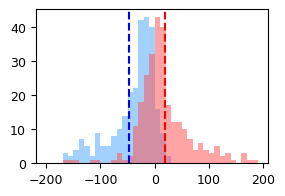

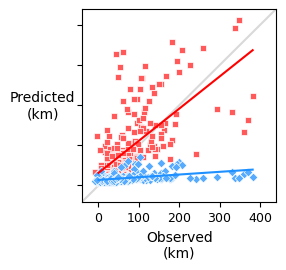

In [364]:
fig, ax= plt.subplots(figsize=(3,2))


COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['X_Pease_numerical'][COND].values


plt.hist(y-x, bins=np.arange(-200,200,10), color=lighter_dodgerblue, alpha=0.55)
plt.axvline(np.nanmean(y-x), c='b', lw=1.5, ls='dashed')

x = DF['length_145max'][COND].values
y = DF['cum_drift'][COND].values

plt.hist(y-x, bins=np.arange(-200,200,10), color=lighter_red, alpha=0.55)

plt.axvline(np.nanmean(y-x), c='r', lw=1.5, ls='dashed')





fig, ax= plt.subplots(figsize=(2.5,2.5))

ax.set_xlim(-40, 440)
ax.set_ylim(-40, 440)
ax.plot([-50,500],[-50,500], c=[0.85]*3,lw=1.5,  zorder=-1)
ax.set_xlabel('Observed\n(km)')
ax.set_ylabel('Predicted\n(km)', rotation=0, labelpad=25, va='center')



COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['cum_drift'][COND].values

mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax.scatter(x, y, s=20, facecolor=lighter_red, alpha=1, marker='s', lw=0.5, edgecolor='w')
ax.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='r', lw=1.5, ls='solid')



COND = (event_cond) #& ((DF.sequence!=119)&(DF.sequence!=150))
x = DF['length_145max'][COND].values
y = DF['X_Pease_numerical'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax.scatter(x,y, s=20, facecolor=lighter_dodgerblue, alpha=1, marker='D', lw=0.5, edgecolor='w')
ax.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='dodgerblue', lw=1.5, ls='solid')
ax.set_xlabel('Observed\n(km)')
ax.tick_params(labelleft=False)

# ax.text(0.95,0.975, f'Slope={resp.slope:.2f}',
#                size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)
# ax.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
#                size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)




# ax.text(0.95,0.975, f'Slope={resp.slope:.2f}',
#               size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_left.transAxes)
# ax.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
#               size = plt.rcParams['font.size']-0.5, ha='right', va='top',  transform = ax2_left.transAxes)

ax.set_ylim()


In [323]:
np.sum((DF['cum_drift'] - DF['length_145max'])[event_cond] > 0)/np.sum(event_cond)

0.6379928315412187

In [308]:
0.678**2

0.45968400000000004

In [307]:
0.45**2

0.2025

In [296]:
set(DF.sequence[event_cond])

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 14,
 15,
 16,
 18,
 19,
 20,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 35,
 38,
 39,
 41,
 42,
 43,
 44,
 49,
 50,
 51,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 88,
 89,
 92,
 93,
 97,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 117,
 118,
 119,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 137,
 138,
 140,
 141,
 143,
 145,
 147,
 148,
 149,
 150,
 151,
 152,
 154,
 156,
 157,
 158,
 159,
 160,
 161,
 162}

In [288]:
np.nanmedian(DF['X_Pease_numerical'][event_cond])

16.600907003482217

In [286]:
np.sum(DF['X_Pease_numerical'][event_cond] < 50) / np.sum(event_cond)

0.967741935483871

In [283]:
np.nanstd(DF['cum_drift'][event_cond] - DF['length_145max'][event_cond])

59.535141664952604

In [282]:
np.nanstd(DF['X_Pease_numerical'][event_cond] - DF['length_145max'][event_cond])

62.95280379943605

In [259]:
timedata['length_145max'][50]

array([ 24.25937948,  52.40683344,  60.30576303, 104.24992744,
       110.8809336 , 105.60694255, 120.11718136, 120.10424162,
       141.65455632, 133.70643028, 180.95356662, 338.19436769,
       346.99149169])

In [258]:
timedata['cum_drift'][50]

array([ 25.95925834,  57.71649949,  87.05413428, 123.695962  ,
       155.45412604, 186.66347294, 227.4458903 , 260.31206861,
       285.18887841, 316.18477417, 343.93361556, 392.9358765 ,
       413.33812257])

In [257]:
timedata['X_Pease_numerical'][50]

array([11.12300408, 16.70057411, 18.78741627, 19.99013865, 21.17362619,
       22.15602003, 21.54336686, 21.15804266, 20.53638986, 19.58201778,
       19.21507494, 18.89658534, 18.45967367])

In [254]:
np.nanmean(DF.Vi[event_cond])

25.581530939701402

In [252]:
np.nanstd(DF.Fi[event_cond])

5.597629849454537

In [148]:
0.677**2

0.45832900000000004

In [149]:
0.447**2

0.19980900000000001

LinregressResult(slope=0.9925564417171017, intercept=21.17022223690646, rvalue=0.6381833328614961, pvalue=2.4382102359456798e-30, stderr=0.07557852810213712, intercept_stderr=5.511493978712672)


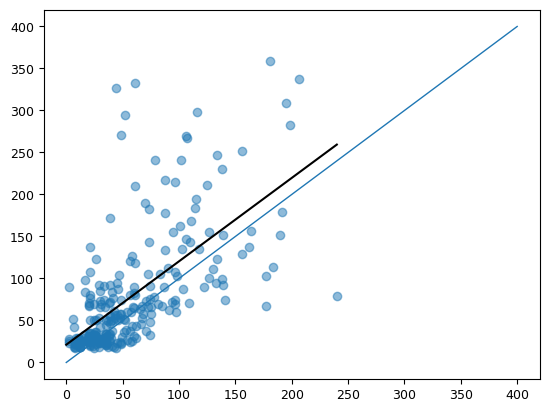

In [110]:
fig, ax = plt.subplots()



# Left plot: cum_drift vs length_145max
COND = ((DF.length_145max > 0) & (event_cond)) & ((DF.sequence!=150)&(DF.sequence!=119))
x = DF['length_145max'][COND].values
y = DF.cum_drift[COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)


ax.scatter(x,y, alpha=0.5)

ax.plot([0,400], [0,400])


ax.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='k', lw=1.5, ls='solid')

In [112]:
DF.sequence[((DF['length_145max'].values>250) & (DF.cum_drift<300)) & event_cond]


4850    119
4851    119
4852    119
5483    150
5484    150
Name: sequence, dtype: int64

### Make plots

In [18]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))

# open and crop elevation data
dsg = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n86.8985_s58.3031_w155.8993_e278.1175.nc')
dsg = dsg.sel(lon = slice(207, 230), lat = slice(69.35,71.6))
g1, g2 = np.gradient(dsg.elevation.values)
depth_gradient = np.sqrt(g1**2+g2**2)


# open regional bounding coordinates
dfp = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((dfp['lons'], dfp['lats']), axis=1))



In [19]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'
# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)




In [20]:

open_thresh=10

map_sic = {}

# for key in list(across.keys())[1::2]:

# for key in ['1','2','3','4','6','8','10','12']:

for key in ['1','4','8','12']:

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(across[key]['date']), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

1
4
8
12


In [21]:

    
poly_maps = {}
for key in across.keys():
    poly_maps[key] = np.zeros_like(dsic['xx'])
    
total_maps = {}
for key in across.keys():
    total_maps[key] = np.zeros_like(dsic['xx'])
    
for key in ['1','4','8','12']:#list(across.keys())[1::2]:
    
    print(key)
    
    for cdate in across[key]['date']:
    
        YEAR = int(cdate.split('-')[0])
        MONTH = int(cdate.split('-')[1])
        if MONTH == 12:
            YEAR+=1

        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{YEAR}_sic10_v7.6_radius25km.nc') as ds2:

            xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
            yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

            total_maps[key] += 1
            
            for xv, yv in zip(xval, yval):

                dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
                poly_maps[key][np.where(dist == 0)] += 1

1
4
8
12


In [735]:
poly_maps.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])

1
4
8
12


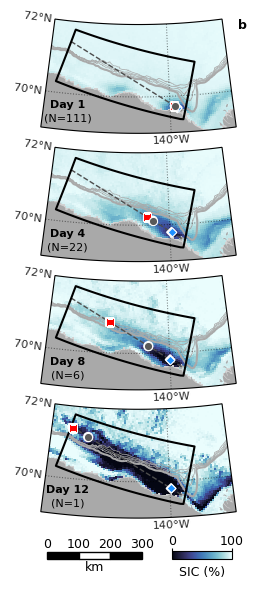

In [31]:
from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


from pyproj import Geod
g = Geod(ellps='WGS84')
startlon, startlat = -139.1, 69.6

wind = timedata['cum_drift'][50]
latt = timedata['X_Pease_numerical'][50]
obss = timedata['length_145max'][50]




# grab box border
clip_path_small = fn.create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(4,1,figsize=(3.5,6.75), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs):#.ravel()):
    
    ax.patch.set_facecolor('lightgray')

    ax.set_boundary(clip_path_small, transform=proj)
    ax.set_extent([lon_range_small[0], lon_range_small[1], 
                   lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
#     ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#                colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


    gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
    gl.xlocator = FixedLocator([ -140])
    gl.ylocator = FixedLocator([70])
    gl.bottom_labels = False
    gl.right_labels = False

#     if ax == axs.ravel()[-1]: 

#     135
    for lat in [70,72]:
        rot = -150.25-(-142.5)
        ax.text(-150.25, lat+0.05, f" {lat}°N",
                transform=ccrs.PlateCarree(),
                ha='right', va='center', c=[0.15]*3, clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
    for lon in [-140]:
        rot = lon-(-142.5)
        ax.text(lon, 68.95, f"{-lon}°W",
                transform=ccrs.PlateCarree(),
                ha='center', va='top',rotation=rot, c=[0.15]*3, clip_on=False, size=plt.rcParams['font.size']-1)
            
            
for n, key in enumerate(['1','4','8','12']):#list(across.keys())[1::2]):
    
    print(key)

    ax = axs.ravel()[n]
    
    ax.text(0.15,0.325,f'Day {key}', weight='bold', ha='center', va='bottom', size=8, transform=ax.transAxes)#, size=FS)
    ax.text(0.15,0.225,f'(N={len(across[key]['date'])})', ha='center', va='bottom',size=8,  transform=ax.transAxes)#, size=FS)
    
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    # Open water frequency
    #---------------------
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'], zorder=0)
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#               vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 100*poly_maps[key]/total_maps[key],#100*map_sic[key]['open_freq'], 
#               levels=[50], colors=['gold'], transform=dsic['proj'], zorder=99)

    # dashed line
    #------------
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    # markers
    #------------
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ 'dodgerblue', 'r', [0.35]*3], 
                                       [ 'white', 'white', 'white'], 
                                       ['D','s', 'o'], [20, 30, 35], [0.75,0.75,0.75]):
    
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=1.5, zorder=101)
    
    
# atmosphere
#-----------
# for ax, key in zip(axs[:], [ '4', '8', '12']):

#     print(key)
    
#     # sea level press
#     #----------------
# #     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
# #                        era_map[key]['msl'][::sp,::sp]/100, 
# #                        vmin=1012,vmax=1028, 
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
# #     mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
# #                        era_map[key]['msl'].mean('time')/100, 
# #                        vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

#     # winds
#     #----------------
#     longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
#     u1 = era_map[key]['u10'].mean('time').values
#     v1 = era_map[key]['v10'].mean('time').values
#     U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
#     sp1, sp2 = 3,6
#     Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
#                   U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0002, width=0.01, headwidth=4,headlength=4, headaxislength=4, 
#                   color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    
ax = axs[0]
ax.text(0.99,1, f'b', weight='bold', 
            ha='left', va='top', transform=ax.transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.0125, cb_length_fraction=[0.7, 1.05], cb_pad=0.015+0.0025, cb_ticks=[0,100], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad=5,#-10, 
                     cb_label_placement='bottom', cb_tick_placement='top', tick_kwargs={'pad':0.1, 'length':2},#, 'length':0, 'labelsize':40, 'length':0.1, 'width':4}, 
                     cb_labelsize=plt.rcParams['font.size'], draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-1], loc=(0.05, -0.15), steps=[100,200,300],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=plt.rcParams['font.size'], lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)


plt.subplots_adjust(hspace=-0.05, )
    
# SAVE(fig, '/Users/mackenziejewell/Desktop/map_panels.png')

SAVE(fig, '../figures/results/pease_model/map_panels.png')

In [157]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)


open_thresh=10

map_SIC = {}

# for key in list(across.keys())[1::2]:

# for key in ['1','2','3','4','6','8','10','12']:

for key in events.keys():

    print(key)
    map_SIC[key] = unisic.calc_meansic_openfreq(pd.to_datetime(events[key]), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


large


In [158]:
events = {}
events['large'] = pd.to_datetime(DF.time[(DF.sequence==119)+(DF.sequence==150)].values)

events

{'large': DatetimeIndex(['2019-12-08', '2019-12-09', '2019-12-10', '2019-12-11',
                '2019-12-12', '2019-12-13', '2019-12-14', '2019-12-15',
                '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
                '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
                '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10',
                '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
                '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18'],
               dtype='datetime64[ns]', freq=None)}

In [168]:

    
poly_maps = {}
for key in events.keys():
    poly_maps[key] = np.zeros_like(dsic['xx'])
    
total_maps = {}
for key in events.keys():
    total_maps[key] = np.zeros_like(dsic['xx'])
    
for key in events.keys():
    
    print(key)
    
    for cdate in events[key]:
    
        YEAR = cdate.year#int(cdate.split('-')[0])
        MONTH = cdate.month#int(cdate.split('-')[1])
        if MONTH == 12:
            YEAR+=1

        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{YEAR}_sic10_v7.6_radius25km.nc') as ds2:

            xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
            yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

            total_maps[key] += 1
            
            for xv, yv in zip(xval, yval):

                dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
                poly_maps[key][np.where(dist == 0)] += 1

large


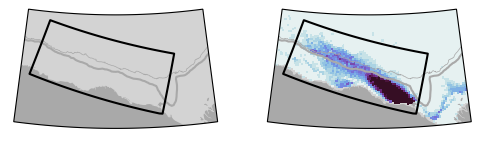

In [204]:
from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)

# grab box border
clip_path_small = fn.create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(6,35), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs):#.ravel()):
    
    ax.patch.set_facecolor('lightgray')

    ax.set_boundary(clip_path_small, transform=proj)
    ax.set_extent([lon_range_small[0], lon_range_small[1], 
                   lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
#     ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#                colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    

    
ax = axs[1]
mesh = ax.pcolormesh(map_SIC[key]['xx'], map_SIC[key]['yy'], 100*map_SIC[key]['open_freq'], 
              vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)

# ax.contour(map_SIC[key]['xx'], map_SIC[key]['yy'], 100*poly_maps[key]/total_maps[key],#100*map_sic[key]['open_freq'], 
#               levels=[25,50], colors=['gold'], transform=dsic['proj'], zorder=99)

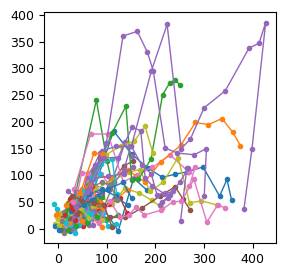

In [203]:
fig, ax = plt.subplots(figsize=(3,3))


# ax.scatter(DF.cum_drift[DF.season_start_flag==False], DF.extent[DF.season_start_flag==False], s=1)

cond = (DF.season_start_flag==False) & (DF.sequence!=-999)

for ss in list(set(DF.sequence[cond])):

    ax.plot(DF.cum_drift[DF.sequence==ss], DF.length_145max[DF.sequence==ss], marker='.')

# ax.scatter(DF.cum_drift[cond&(DF.sequence==119)], DF.length_145max[cond&(DF.sequence==119)], s=1)
# ax.scatter(DF.cum_drift[cond&(DF.sequence==150)], DF.length_145max[cond&(DF.sequence==150)], s=1)

In [234]:
dfr.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'a10_r', 'ai_r', 'centermass_direction_r', 'max_length_direction_r',
       'east_wind_event', 'strong_wind_event', 'strong_east_wind_event',
       'Qnet', 'Fi', 'Vi', 'cum_drift', 'X_Pease_limiting',
       'X_Pease_numerical', 'Pease_t95', 'east_maintained'],
      dtype='object')

In [246]:
dfr['up'] = dfr['centermass_length'].values * np.cos(dfr['centermass_direction'].values*np.pi/180)
dfr['vp'] = dfr['centermass_length'].values * np.sin(dfr['centermass_direction'].values*np.pi/180)

# dfr['up'] = dfr['length_max'].values * np.cos(dfr['max_length_direction'].values*np.pi/180)
# dfr['vp'] = dfr['length_max'].values * np.sin(dfr['max_length_direction'].values*np.pi/180)
                     

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_2510/364522236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr['up'] = dfr['centermass_length'].values * np.cos(dfr['centermass_direction'].values*np.pi/180)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_2510/364522236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr['vp'] = dfr['centermass_length'].values * np.sin(dfr['centermass_direction'].values*np.pi/180)


In [247]:
cond = (dfr.year==2017)+(dfr.year==2018)

pa = vectors.vector_angle(np.nanmean(dfr['up'][cond]), np.nanmean(dfr['vp'][cond]))

(90*units('degree')-pa) + 360*units('degree')

<Quantity(304.121733, 'degree')>

# Old Versions

## Reference grids

In [4]:
# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))



## Open compiled stats

In [11]:
df = pd.read_csv('../data/compiled_stats.csv')




# calculate estimated ice drift along polynya axis

# model params
#===============================
wf = 0.03 # wind factor
ta = 20   # CW turning angle wind to ice, degrees
poly_dir = 145  #  polynya direction, degrees CCW from E
#===============================

# observed wind speed and direction
wind_speed = np.sqrt(df['u10'].values**2 + df['v10'].values**2) * units('m/s')
wind_dir = vectors.vector_angle(df['u10'].values, df['v10'].values)

# predicted ice speed and direction
ice_speed = wf * wind_speed.to('km/day')
ice_dir = wind_dir - (ta*units('degree'))

# back to components
ice_u = ice_speed * np.cos(ice_dir.to('radian').magnitude)
ice_v = ice_speed * np.sin(ice_dir.to('radian').magnitude)

# component of ice drift along polynya direction
ice_comp_along_polynya = vectors.comp_along_theta(ice_u, ice_v, poly_dir*units('degree'))

# component of ice drift along polynya orientation
df['est_ice_along_polynya'] = ice_comp_along_polynya







df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.03*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
df['si_km'] = df['si'] * units('cm/s').to('km/day')

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    angles = 90-df[f'{cat}']
    angles[angles<0]+=360
    df[f'{cat}_r'] = angles
    
df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude

df['cum_drift'] = 0
df['X_Pease'] = 0
df['X_Pease_num'] = 0
df['Vi'] = 0
df['Fi'] = 0
df['t95'] = 0
seqs = np.array(list(set(df.sequence[df.sequence!=-999])))

for ss in seqs:
    df.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(df.loc[df.sequence == ss, 'est_ice_along_polynya']).values
    

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_96019/1157400083.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-14.81389767]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(df.loc[df.sequence == ss, 'est_ice_along_polynya']).values


In [15]:
def find_sequences(bool_array):

    # Find the edges of the False sequences
    padded = np.pad(bool_array, (1, 1), constant_values=0)
    diff = np.diff(padded.astype(int))

    # Start indices: where diff == 1, End indices: where diff == -1
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]

    return list(zip(starts, ends))  # Each tuple is (start, end) of a sequence


# create wind sequences
#----------------------
df['wind_seq'] = -999

wind_events = np.copy(dir_conds(df, 'wind') & speed_conds(df, 'wind'))
wind_events = (wind_events & (df.season_start_flag==False)) & ((df.year!=2012)&(df.year>=2003))#((df.year!=2012)&(df.year<2016))
wind_seqs = find_sequences(wind_events)

for ii, ss in enumerate(wind_seqs):
    for sss in np.arange(ss[0],ss[1]):
        df.loc[df.index == df.index.values[sss], 'wind_seq'] = ii
        
        
wind_sequences = list(set(df.wind_seq[(df.wind_seq!=-999)]))


# calc ice drift during
#----------------------      
df['wind_event_day'] = -999
df['wind_event_length'] = -999
df['polynya_has_opened'] = False

for ww in wind_sequences:
    # grab event indices
    event_indices = (df[df.wind_seq == ww]).index

    df.loc[df.wind_seq == ww, 'wind_event_day'] = np.arange(1, len(event_indices)+1)
    df.loc[df.wind_seq == ww, 'wind_event_length'] = np.full(len(event_indices), len(event_indices))
    
    # grab event indices
    event_indices = (df[df.wind_seq == ww]).index

    # determine if polynya opens
    # if so, start event from when it opens
    is_open = np.where(df[df.wind_seq == ww].extent>0)[0]
    if len(is_open)>0:
        df.loc[event_indices[is_open[0]:], 'polynya_has_opened'] = True
            

            
df['cum_drift_once_open'] = 0       
for ww in wind_sequences:
    cum_drift_during = np.cumsum(df.loc[(df.wind_seq == ww)&(df.polynya_has_opened)].ese10)
    df.loc[(df.wind_seq == ww)&(df.polynya_has_opened), 'cum_drift_once_open'] = cum_drift_during 

    
    
    
   

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/203897369.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20.38337883]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df.wind_seq == ww)&(df.polynya_has_opened), 'cum_drift_once_open'] = cum_drift_during


# Run the Pease model

In [66]:

for IND in np.where(df.year >= 2003)[0]:
    
    # model params
    #===============================
    wf = 0.03 # wind factor
    ta = 20   # CW turning angle wind to ice, degrees
    poly_dir = 145  #  polynya direction, degrees CCW from E
    Hi = 10 * units('cm')
    #===============================

#     for IND in np.where(df.sequence == ss)[0]:
    out = Pease_Model_v2(df.iloc[IND:IND+1], wf=wf, ta=ta, poly_dir=poly_dir, Hi = Hi, show_plot = False)
    X_num, X_max, t95, X_zip, Ta, Vi, wind_speed, east_wind, Fi = out
    
    # set undefined Pease widths to cumulative drift 
    # expected from ice drift alone
    if t95 < 30 * units('day'):
        df.loc[IND, 'X_Pease'] = X_max.magnitude.item()
#         df.loc[IND, 'X_Pease_num'] = X_num
    
    else:
        df.loc[IND, 'X_Pease'] = df.loc[IND].cum_drift
        
    df.loc[IND, 't95'] = t95
    df.loc[IND, 'Vi'] = Vi
    df.loc[IND, 'Fi'] = Fi
        

# identify base period
dfb = df[df['2003_2023']]
dfr = df[df.year >= 2003]

In [ ]:
# XP = np.array([L.magnitude.item() for L in DF.X_Pease.values])
# XP_num = np.array([L.magnitude.item() for L in DF.X_Pease_num.values])
# # np.where(np.isfinite(XP), XP,  DF.cum_drift.values)

# DF['X_Pease_addressnans'] = np.where(np.isfinite(XP), XP,  DF.cum_drift.values)

In [17]:
time_cond = (df.year==2018) + (df.year==2017)

est_growth = np.array([fi.item().magnitude for fi in df['Fi'][time_cond & (df.extent>0)]])
print(f'Fi = {np.nanmean(est_growth):.2f} +/- {np.nanstd(est_growth):.2f} cm/day')



Fi = 7.89 +/- 4.11 cm/day


In [2730]:
len(np.array([fi.item().magnitude for fi in df['Fi'][time_cond & (df.extent>0)]]))

73

In [2417]:
for month in [12,1,2,3,4]:
    
    cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
    cond = cond & (dfr['month']==month)
    
    print(dfr['time'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    print(dfr['sequence'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    

4851    2019-12-12
Name: time, dtype: object
4851    119
Name: sequence, dtype: int64
5489    2024-01-14
Name: time, dtype: object
5489    150
Name: sequence, dtype: int64
5232    2022-02-28
Name: time, dtype: object
5232    135
Name: sequence, dtype: int64
5697    2025-03-11
Name: time, dtype: object
5697    160
Name: sequence, dtype: int64
4368    2016-04-12
Name: time, dtype: object
4368    86
Name: sequence, dtype: int64


In [80]:
cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
all_ss = list(set(dfr['sequence'][cond]))


# cond = ((dfr['sequence']!=-999))
# all_ss = list(set(dfr['sequence'][cond]))


### Define direction ranges

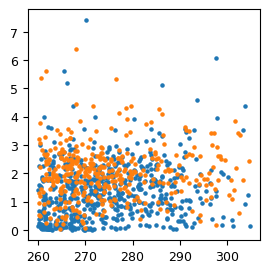

In [715]:
late_df = df[df.year >= 2016]
earl_df = df[(df.year >= 2003)&(df.year < 2016)]

fig, ax= plt.subplots(figsize=(3,3))

cond =  (earl_df.s10 > 3) &dir_conds(earl_df, 'wind') 
# plt.hist(earl_df[cond]['a10_r'], bins=np.arange(255,310,2), alpha=0.5, density=True)

plt.scatter(earl_df[cond]['a10_r'], earl_df[cond]['si']/earl_df[cond]['s10'], s=5)


cond = (late_df.s10 > 3) &dir_conds(late_df, 'wind') 
# plt.hist(late_df[cond]['a10_r'], bins=np.arange(255,310,2), alpha=0.5, density=True)
plt.scatter(late_df[cond]['a10_r'], late_df[cond]['si']/late_df[cond]['s10'], s=5)

In [83]:
0.017 * 6 * units('m/s').to('km/day')

<Quantity(8.8128, 'kilometer / day')>

In [84]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.8076190476190476

In [85]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.6876190476190476

In [86]:
def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    

In [ ]:

shoulder = (DF.month==1) 

In [ ]:
omit_events =

In [1043]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'esei', 'ese10', 'si_km', 'a10_r', 'ai_r', 'centermass_direction_r',
       'max_length_direction_r', 'up', 'vp', 'ta_wi', 'ta_ip', 'ta_wp',
       'cum_drift', 'X_Pease', 'X_Pease_num', 'Vi', 'Fi', 't95'],
      dtype='object')

In [1046]:
pd.to_datetime(DF.time.values).day

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype='int32', length=3479)

### Specify conditions

In [71]:
#=============
L = 13
#=============


#=============
DF = dfr
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

# shoulder = ((DF['season_start_flag'] + DF['season_end_flag']) + DF['final_day'])


# identify periods where east winds maintained over whole event 


# east_maint = np.copy(speed_conds(DF, 'wind').values)
east_maint = np.copy(dir_conds(DF, 'wind').values & speed_conds(DF, 'wind').values)
# east_maint = np.copy(dir_conds(DF, 'wind').values)
# east_maint = np.copy(DF.u10.values<0)
print(np.sum(east_maint))

for ss in list(set(DF.sequence[DF.sequence!=-999])):
    
    # sequence index start
    II = np.where(DF.sequence.values==ss)[0][0]
    FF = np.where(DF.sequence.values==ss)[0][-1]
    
    east__ = (dir_conds(DF[DF.sequence==ss], 'wind').values) & (speed_conds(DF[DF.sequence==ss], 'wind').values)
    not_east = (east__==False)
    
#     not_east = (speed_conds(DF[DF.sequence==ss], 'wind').values == False)
#     not_east = (dir_conds(DF[DF.sequence==ss], 'wind').values == False)

    # if a not-east event is found
    if len(np.where(not_east)[0]) > 0:
        # everywhere after first not-east event (up to end of event) is false
        east_maint[II+np.where(not_east)[0][0]:FF+1] = False
    
    
    
# shoulder = ((DF['season_start_flag'] + DF['season_end_flag']))# + DF['final_day'])

# shoulder_sta = (DF.month==12) & (pd.to_datetime(DF.time.values).day <15)
# shoulder_end = (DF.month==4) & (pd.to_datetime(DF.time.values).day >15)

# shoulder = shoulder_sta + shoulder_end

shoulder = (DF['season_start_flag']) #+ ((DF['month']==3)+(DF['month']==4))

event_cond = (shoulder==False) & east_maint#& (DF.final_day==False) #& (east_maint==True)# + DF['final_day'])

# shoulder_si = (DF['season_start_flag'] + DF['season_end_flag']) 

# shoulder = DF.year<0

comp_ = (DF.extent==0)
comp_[(DF.day_before_event>=-3)]=False
comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False

days_before = np.array([-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [((DF['day_before_event'] == dd)&(DF['before_event_length']>=1))&(shoulder==False) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
# conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
# conds_during = [(DF['event_day'] == dd) for dd in days_during]
conds_during = [((DF['event_day'] == dd)&(event_cond)) for dd in days_during]
# conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)

days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
# conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]
conds_more = [((DF['event_day'] > L))&(event_cond)]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))]   

days_after = np.array([1,2])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [((DF['day_after_event'] == dd)&(DF['after_event_length']>=1))&(shoulder==False) for dd in days_after]   


# x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
# x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
# all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))


# x_values = np.concatenate((1+days_before, days_during, days_more, 1+L+days_after))
# x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_after))
# all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_after))


# x_values = np.concatenate((days_during, days_more))
# x_labels = np.concatenate((labels_during, labels_more))
# all_cond = np.concatenate((conds_during, conds_more))


x_values = days_during 
x_labels = labels_during
all_cond = conds_during


across = {}
for dd, cond in zip(x_labels, all_cond):

    across[dd] = {}
    across[dd]['date'] = DF.time[cond].values


3
160
646


In [72]:
list(set(DF.sequence[DF['season_start_flag']]))

[1, 33, 17, 24, 123]

In [73]:
len(DF.sequence[DF['season_start_flag']])

21

In [75]:

# XP = np.array([L.magnitude.item() for L in DF.X_Pease.values])
# XP_num = np.array([L.magnitude.item() for L in DF.X_Pease_num.values])
# np.where(np.isfinite(XP), XP,  DF.cum_drift.values)

# DF['X_Pease_addressnans'] = np.where(np.isfinite(XP), XP,  DF.cum_drift.values)

percents = [5,10,25,50,75,90,95]
also = ['avg', 'std', 'avg_ms', 'avg_ps']

#----------------------
VAR = 'X_Pease'
lat_pers = {}
for per in percents:
    lat_pers[per] = np.array([])
for per in also:
    lat_pers[per] = np.array([])
    
for dd, cond in zip(x_values, all_cond):
    for per in percents:
        lat_pers[per] = np.append(lat_pers[per], np.nanpercentile(DF[VAR][cond], per))
    lat_pers['avg'] = np.append(lat_pers['avg'], np.nanmean(DF[VAR][cond]))
    lat_pers['std'] = np.append(lat_pers['std'], np.nanstd(DF[VAR][cond]))
    
    lat_pers['avg_ms'] = np.append(lat_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    lat_pers['avg_ps'] = np.append(lat_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))
        
        
#----------------------        
VAR = 'length_145max'
# VAR = 'width'
obs_pers = {}
for per in percents:
    obs_pers[per] = np.array([])
for per in also:
    obs_pers[per] = np.array([])
    
for dd, cond in zip(x_values, all_cond):
    for per in percents:
        obs_pers[per] = np.append(obs_pers[per], np.nanpercentile(DF[VAR][cond], per))
    obs_pers['avg'] = np.append(obs_pers['avg'], np.nanmean(DF[VAR][cond]))
    obs_pers['std'] = np.append(obs_pers['std'], np.nanstd(DF[VAR][cond]))
    
    obs_pers['avg_ms'] = np.append(obs_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    obs_pers['avg_ps'] = np.append(obs_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))
        
    
#----------------------        
VAR = 'cum_drift'
pred_pers = {}
for per in percents:
    pred_pers[per] = np.array([])
for per in also:
    pred_pers[per] = np.array([])

for dd, cond in zip(x_values, all_cond):
    for per in percents:
        pred_pers[per] = np.append(pred_pers[per], np.nanpercentile(DF[VAR][cond], per))
    pred_pers['avg'] = np.append(pred_pers['avg'], np.nanmean(DF[VAR][cond]))
    pred_pers['std'] = np.append(pred_pers['std'], np.nanstd(DF[VAR][cond]))
    
    pred_pers['avg_ms'] = np.append(pred_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    pred_pers['avg_ps'] = np.append(pred_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))

<>:179: SyntaxWarning: invalid escape sequence '\m'
<>:179: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/3335406920.py:179: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


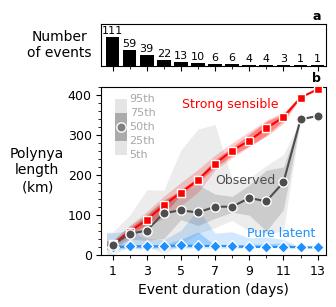

In [76]:
fig, axs = plt.subplots(2,1,figsize=(2.9,3), gridspec_kw={'height_ratios':[0.25,1]})


    
color1 = 'k'#[50/255,115/255, 255/255]   
color2 = 'darkgray'# [137/255,173/255, 255/255]   
    
    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,160)
ax.set_yticks([])
ax.set_ylabel('Number\nof events', rotation=0, labelpad=30, va='center')
for dd, cond in zip(x_values, all_cond):
    
    if (dd >0)&(dd < 15):
        ax.bar(dd, np.sum(cond), color=color1)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color1, va='bottom', ha='center', size=8)
    else:
        ax.bar(dd, np.sum(cond), color=color2)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color2, va='bottom', ha='center', size=8)
# ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='k', size = 7.5,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-1.75+1.25, x_values.max()+1.75-1.25)
    ax.set_xticks(x_values)
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels);
# plt.xticks(fontsize=9)



wi = 0.2
hi = 8

bff = 0.35
lo = 0

weight='normal'


#-----------------
category = pred_pers
color = 'r'

ax.text(0.575,0.875,'Strong sensible', ha='center', weight=weight, c=color, transform=ax.transAxes)

ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='s', s=40,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)


# ax.plot(x_values+lo, category[10], lw=0.5, c=color, ls='dashed',   zorder=99)
# ax.plot(x_values+lo, category[90], lw=0.5, c=color, ls='dashed',   zorder=99)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))

# Y1_exp = np.concatenate((np.array([category[10][0]]), category[10], np.array([category[10][-1]])))
# Y2_exp = np.concatenate((np.array([category[90][0]]), category[90], np.array([category[90][-1]])))

# Y1_exp = np.concatenate((np.array([category['avg_ms'][0]]), category['avg_ms'], np.array([category['avg_ms'][-1]])))
# Y2_exp = np.concatenate((np.array([category['avg_ps'][0]]), category['avg_ps'], np.array([category['avg_ps'][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.35, color=color, lw=0 ,zorder=-4)


Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-6)

    
#-----------------

category = lat_pers
color = 'dodgerblue'
ax.text(0.95,0.11,'Pure latent', ha='right', weight=weight, c=color, transform=ax.transAxes)


ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='D', s=35,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.3, color=color, lw=0 ,zorder=-4)

Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-6)

    

#-----------------
category = obs_pers
color = [0.3]*3

ax.text(0.775,0.425, 'Observed', ha='right', weight=weight, c=color, transform=ax.transAxes)


ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='o', s=45,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)


# ax.plot(x_values+lo, category[10], lw=0.5, c=color, ls='dashed',   zorder=99)
# ax.plot(x_values+lo, category[90], lw=0.5, c=color, ls='dashed',   zorder=99)


# ax.plot(x_values, category[25],alpha=1, color=color, lw=0.5, ls='dashed', zorder=-4)
# ax.plot(x_values, category[75],alpha=1, color=color, lw=0.5, ls='dashed', zorder=-4)

# ax.fill_between(x_values, category[25], category[75], alpha=0.25, color=color, lw=0 ,zorder=-4)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))

# Y1_exp = np.concatenate((np.array([category[10][0]]), category[10], np.array([category[10][-1]])))
# Y2_exp = np.concatenate((np.array([category[90][0]]), category[90], np.array([category[90][-1]])))


# Y1_exp = np.concatenate((np.array([category['avg_ms'][0]]), category['avg_ms'], np.array([category['avg_ms'][-1]])))
# Y2_exp = np.concatenate((np.array([category['avg_ps'][0]]), category['avg_ps'], np.array([category['avg_ps'][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-4)

Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.1, color=color, lw=0 ,zorder=-6)


    
# Get the y-axis tick labels
xtick_labels = axs[-1].get_xticklabels()

axs[-1].set_xlabel('Event duration (days)')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 1.025, f'{chr(97+aa)}', 
                ha='right', va='bottom', weight='bold', clip_on=False, transform = ax.transAxes)
    else:
        ax.text(0.975, 1.01, f'{chr(97+aa)}', 
                ha='right', va='bottom', weight='bold', clip_on=False, transform = ax.transAxes)

    
plt.subplots_adjust(hspace=0.2)


# for dd in x_values:
#     ax.axvline(dd, c='lightgray', lw=0.5, zorder=-100)
# for dd in [100,200,300]:
#     ax.axhline(dd, c='lightgray', lw=0.5, zorder=-100)
    
for ax in axs:
    ax.set_xlim(0.35,x_values.max()+.5)
    ax.xaxis.set_major_locator(ticker.FixedLocator([1,3,5,7,9,11,13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    

# for ax in axs[2:2]:
#     ax.set_ylim(0,1.05)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
#     ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


ax = axs[1]
ax.set_ylim(0,420)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


xxx = 1.5
ax.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45,facecolor='gray', zorder=100)

X_exp = np.linspace(xxx-0.35,xxx+0.35, 3)
Y1_exp = np.full(3, 285)
Y2_exp = np.full(3, 355)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.25, color='k', lw=0 ,zorder=-6)
Y1_exp = np.full(3, 250)
Y2_exp = np.full(3, 390)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.1, color='k', lw=0 ,zorder=-6)


color = [0.65]*3
ax.text(xxx+0.5,320, '50th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,355, '75th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,390, '95th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,285, '25th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,250, '5th', ha='left', va='center', c=color, size=8)

# ax.plot(x_values[2:-4], np.linspace(0,200,len(x_values[2:-4])))
# fig.savefig('../figures/results/comp_time_v2.png', dpi=400, bbox_inches='tight')

fig.savefig('/Users/mackenziejewell/Desktop/timeseries.png', dpi=400, bbox_inches='tight')

<>:92: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/2431356485.py:92: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


LinregressResult(slope=0.5683479568171372, intercept=19.307019136775324, rvalue=0.6771073093549118, pvalue=7.796620546903976e-38, stderr=0.03759104957927599, intercept_stderr=4.3813894461562795)
LinregressResult(slope=0.3386962374522305, intercept=58.89651032272298, rvalue=0.10524629952794524, pvalue=0.08316899495222194, stderr=0.19476142410944414, intercept_stderr=6.503555058061744)
37.980427843301314 64.58043679567001
-16.854233452850654 65.08112529292944


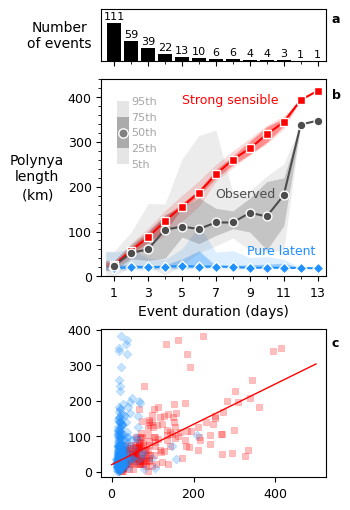

In [111]:
fig, axs = plt.subplots(3,1,figsize=(2.9,6.5), gridspec_kw={'height_ratios':[0.25,1,0.75]})



ax = axs[0]
ax.set_ylim(0,150)
ax.set_yticks([])
ax.set_ylabel('Number\nof events', rotation=0, labelpad=30, va='center')
for dd, cond in zip(x_values, all_cond):
    ax.bar(dd, np.sum(cond), color='k')
    ax.text(dd, np.sum(cond)+5, np.sum(cond), 
            color='k', va='bottom', ha='center', size=8)


ax = axs[1]

weight = 'normal'
ax.text(0.575,0.875,'Strong sensible', ha='center', weight=weight, c='r', transform=ax.transAxes)
ax.text(0.95,0.11,'Pure latent', ha='right', weight=weight, c='dodgerblue', transform=ax.transAxes)
ax.text(0.775,0.4, 'Observed', ha='right', weight=weight, c=[0.3]*3, transform=ax.transAxes)

bff = 0.5

for category, color, marker, size, alpha1, alpha2 in zip([lat_pers,
                               pred_pers, 
                               obs_pers,], 
                      ['dodgerblue', 'r', [0.3]*3], ['D', 's', 'o'], [30,30,40], [0.35,0.35,0.25], [0.15,0.15,0.1]):
    
    ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker=marker, s=size,facecolor=color, zorder=100)
    ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)


    X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
    Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
    Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))
    
    ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=alpha1, color=color, lw=0 ,zorder=-4)
    
    
    X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
    Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
    Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
    ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=alpha2, color=color, lw=0 ,zorder=-4)
    
    
    
# label the percentiles
#----------------------
    
xxx = 1.5
ax.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45,facecolor='gray', zorder=100)

X_exp = np.linspace(xxx-0.35,xxx+0.35, 3)
Y1_exp = np.full(3, 285)
Y2_exp = np.full(3, 355)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.25, color='k', lw=0 ,zorder=-6)
Y1_exp = np.full(3, 250)
Y2_exp = np.full(3, 390)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.1, color='k', lw=0 ,zorder=-6)

color = [0.65]*3
ax.text(xxx+0.5,320, '50th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,355, '75th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,390, '95th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,285, '25th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,250, '5th', ha='left', va='center', c=color, size=8)



    
axs[0].set_xticklabels([])
axs[1].set_xlabel('Event duration (days)')

for aa, ax in enumerate(axs):
    ax.text(1.025, 0.95, f'{chr(97+aa)}', 
            ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
  
for ax in axs[:-1]:
    ax.set_xlim(0.25,x_values.max()+.5)
    ax.xaxis.set_major_locator(ticker.FixedLocator([1,3,5,7,9,11,13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    


plt.subplots_adjust(hspace=0.4)

ax = axs[1]
ax.set_ylim(0,440)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')

axs[0].set_position([0.125, 0.75, 0.775, 0.08])
    
    
ax = axs[2]

# vals1 = (all_values['length_145max'] - all_values['X_Pease'])#[all_values['day']>2],
# ax.hist(vals1,
#         bins=np.arange(-400,400,15), 
#         color='dodgerblue', alpha=0.5)
# plt.axvline(np.nanmean(vals1), c='dodgerblue', lw=1.5)

# vals2 = (all_values['length_145max'] - all_values['cum_drift_once_open'])#[all_values['day']>2]
# ax.hist(vals2, 
#         bins=np.arange(-400,400,15), 
#         color='r', alpha=0.35)
# plt.axvline(np.nanmean(vals2), c='r', lw=1.5)
# ax.set_xlim(-200,200)


# shoulder = ((DF['season_start_flag'])) #+ (east_maint==False)# + DF['season_end_flag']))# + DF['final_day'])

COND = ((DF.length_145max>0) & (event_cond)) #& ((DF.event_day >=5)) #& (DF.sequence!=150)
# COND = ((DF.length_145max>0) & (shoulder==False) ) #&(DF.event_day > 2) # & ((east_maint))
# COND = ((DF.event_day > 2)& (shoulder==False) )

# COND = ((DF.length_145max>0) & (event_cond)) & (east_maint)
# COND = ((DF.length_145max>0) & (DF['season_start_flag']==False)) #& (DF.event_day == 3)

# np.where(np.isfinite(XP), XP,  DF.cum_drift.values)

#----------------
x = DF.cum_drift[COND].values
y = DF['length_145max'][COND].values

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)
ax.scatter(x,y,s=20,  facecolor='r', alpha=0.25,marker='s', lw=0.5)

x_line = np.arange(0,500)
y_line = resp.slope*x_line + resp.intercept
ax.plot(x_line, y_line, c='r')



#----------------
x = DF['X_Pease'][COND].values.astype(float)
y = DF['length_145max'][COND].values

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)

ax.scatter(x,y, s=20, facecolor='dodgerblue', alpha=0.25, marker='D', lw=0.5)

x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept
# ax.plot(x_line, y_line, c='dodgerblue')




print(np.nanmean(vals1), np.nanstd(vals1))
print(np.nanmean(vals2), np.nanstd(vals2))

fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')

<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/1018278307.py:54: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


LinregressResult(slope=0.5683479568171372, intercept=19.307019136775324, rvalue=0.6771073093549118, pvalue=7.796620546903976e-38, stderr=0.03759104957927599, intercept_stderr=4.3813894461562795)
LinregressResult(slope=0.3386962374522305, intercept=58.89651032272298, rvalue=0.10524629952794524, pvalue=0.08316899495222194, stderr=0.19476142410944414, intercept_stderr=6.503555058061744)


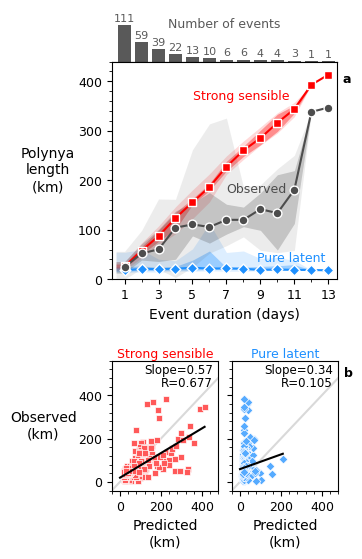

In [275]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 6.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 0.35], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2_left = fig.add_subplot(gs[2, 0])
ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.425+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.425, 0.75, 0.335]) 
ax2_left.set_position([0.1, 0.1, 0.355, 0.2]) 
ax2_right.set_position([0.5, 0.1, 0.355, 0.2]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = [0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.6,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(20))


# Text labels
ax1.text(0.575, 0.825, 'Strong sensible', ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.95, 0.08, 'Pure latent', ha='right', c='dodgerblue', transform=ax1.transAxes)
ax1.text(0.775, 0.4, 'Observed', ha='right', c=[0.3]*3, transform=ax1.transAxes)



bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    [lat_pers, pred_pers, obs_pers],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, category[50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, category[50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([category[low][0]], category[low], [category[low][-1]]))
        Y2_exp = np.concatenate(([category[high][0]], category[high], [category[high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
# xxx = 1.5
# ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
# for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
#     ax1.fill_between(np.linspace(xxx - 0.35, xxx + 0.35, 3), 
#                      np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
# color = [0.65]*3
# for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
#     ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)

    
# --- Bottom Two Side-by-Side Subplots ---
# ax2_left = fig.add_subplot(gs[2, 0])
# ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)

ax2_left.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_left.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.xaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.xaxis.set_minor_locator(ticker.MultipleLocator(40))

# Left plot: cum_drift vs length_145max
COND = ((DF.length_145max > 0) & (event_cond))
x = DF.cum_drift[COND].values
y = DF['length_145max'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

for ax in [ax2_left, ax2_right]:
    ax.set_xlim(-40, 480)
    ax.set_ylim(-40, 560)
    ax.plot([-50,500],[-50,500], c=[0.85]*3,lw=1.5,  zorder=-1)

ax2_left.scatter(x, y, s=20, facecolor=lighter_red, alpha=1, marker='s', lw=0.5, edgecolor='w')
ax2_left.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='k', lw=1.5, ls='solid')
ax2_left.set_xlabel('Predicted\n(km)')
ax2_left.set_ylabel('Observed\n(km)', rotation=0, labelpad=25, va='center')

ax2_left.text(0.95,0.975, f'Slope={resp.slope:.2f}',
              size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_left.transAxes)
ax2_left.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
              size = plt.rcParams['font.size']-0.5, ha='right', va='top',  transform = ax2_left.transAxes)


# Right plot: X_Pease vs length_145max
x = DF['X_Pease'][COND].values.astype(float)
y = DF['length_145max'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax2_right.scatter(x,y, s=20, facecolor=lighter_dodgerblue, alpha=1, marker='D', lw=0.5, edgecolor='w')
ax2_right.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c='k', lw=1.5, ls='solid')
ax2_right.set_xlabel('Predicted\n(km)')
ax2_right.tick_params(labelleft=False)

ax2_right.text(0.95,0.975, f'Slope={resp.slope:.2f}',
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)
ax2_right.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',   transform = ax2_right.transAxes)


offset = [0,0.025]
for i, ax in enumerate([ax1, ax2_right]):
    ax.text(1.025+offset[i], 0.95, f'{chr(97 + i)}', ha='left', va='top', weight='bold', transform=ax.transAxes)

ax2_left.text(0.5,1, 'Strong sensible', color='r', ha='center', va='bottom', transform=ax2_left.transAxes)
ax2_right.text(0.5,1, 'Pure latent', color='dodgerblue', ha='center', va='bottom', transform=ax2_right.transAxes)
    


fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')


<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/1746754917.py:54: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


LinregressResult(slope=0.5683479568171372, intercept=19.307019136775324, rvalue=0.6771073093549118, pvalue=7.796620546903976e-38, stderr=0.03759104957927599, intercept_stderr=4.3813894461562795)
LinregressResult(slope=0.3386962374522305, intercept=58.89651032272298, rvalue=0.10524629952794524, pvalue=0.08316899495222194, stderr=0.19476142410944414, intercept_stderr=6.503555058061744)


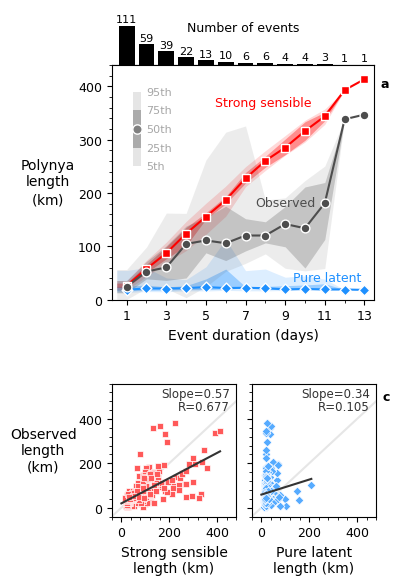

In [337]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3.5, 7))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.25, 1, 0.35], width_ratios=[1, 1])
gs.update(hspace=0.1)


# create subplots
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2_left = fig.add_subplot(gs[2, 0])
ax2_right = fig.add_subplot(gs[2, 1], sharey=ax2_left)


for spine in ['top', 'left', 'right']:
    ax0.spines[spine].set_linewidth(0)

# Manually position each subplot: [left, bottom, width, height]
ax0.set_position([0.1, 0.41+0.335, 0.75, 0.08])     
ax1.set_position([0.1, 0.41, 0.75, 0.335]) 
ax2_left.set_position([0.1, 0.1, 0.355, 0.19]) 
ax2_right.set_position([0.5, 0.1, 0.355, 0.19]) 


for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 3, 5, 7, 9, 11, 13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0.25, x_values.max() + .5)


# --- Top Bar Plot ---
# ax0 = fig.add_subplot(gs[0, :])
color = 'k'#[0.35]*3
ax0.set_ylim(0, 160)
ax0.set_yticks([])
# ax0.set_ylabel('Number\nof events', c=color, rotation=0, labelpad=30, va='center')

ax0.text(0.5,0.55,'Number of events', c=color, va='bottom', ha='center', transform=ax0.transAxes)

for dd, cond in zip(x_values, all_cond):
    total = np.sum(cond)
    ax0.bar(dd, total, color=color, lw=1)
    ax0.text(dd, total + 5, total, color=color, va='bottom', ha='center', size=8)

ax0.set_xticklabels([])

# --- Middle Line/Scatter Plot ---
# ax1 = fig.add_subplot(gs[1, :])
ax1.set_ylim(0, 440)
ax1.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')
ax1.set_xlabel('Event duration (days)')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(20))


# Text labels
ax1.text(0.575, 0.825, 'Strong sensible', ha='center', c='r', transform=ax1.transAxes)
ax1.text(0.95, 0.08, 'Pure latent', ha='right', c='dodgerblue', transform=ax1.transAxes)
ax1.text(0.775, 0.4, 'Observed', ha='right', c=[0.3]*3, transform=ax1.transAxes)



bff = 0.5
for category, color, marker, size, alpha1, alpha2 in zip(
    [lat_pers, pred_pers, obs_pers],
    ['dodgerblue', 'r', [0.3]*3],
    ['D', 's', 'o'],
    [30, 30, 40],
    [0.35, 0.35, 0.25],
    [0.15, 0.15, 0.1]
):
    ax1.scatter(x_values + lo, category[50], lw=1, edgecolor='white', marker=marker,
                s=size, facecolor=color, zorder=100)
    ax1.plot(x_values + lo, category[50], lw=1.5, c=color, ls='solid', zorder=99)

    for low, high, alpha in [(25, 75, alpha1), (5, 95, alpha2)]:
        X_exp = np.concatenate(([x_values.min() - bff], x_values, [x_values.max() + bff]))
        Y1_exp = np.concatenate(([category[low][0]], category[low], [category[low][-1]]))
        Y2_exp = np.concatenate(([category[high][0]], category[high], [category[high][-1]]))
        ax1.fill_between(X_exp, Y1_exp, Y2_exp, alpha=alpha, color=color, lw=0, zorder=-4)

# # Add percentile legend        
xxx = 1.5
ax1.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45, facecolor='gray', zorder=100)
for low, high, alpha, ypos in [(285, 355, 0.25, '75th'), (250, 390, 0.1, '95th')]:
    ax1.fill_between(np.linspace(xxx - 0.2, xxx + 0.2, 3), 
                     np.full(3, low), np.full(3, high), alpha=alpha, color='k', lw=0, zorder=-6)
color = [0.65]*3
for ypos, label in zip([320, 355, 390, 285, 250], ['50th', '75th', '95th', '25th', '5th']):
    ax1.text(xxx + 0.5, ypos, label, ha='left', va='center', c=color, size=8)


ax2_left.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.yaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_left.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_left.xaxis.set_minor_locator(ticker.MultipleLocator(40))

ax2_right.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax2_right.xaxis.set_minor_locator(ticker.MultipleLocator(40))

# Left plot: cum_drift vs length_145max
COND = ((DF.length_145max > 0) & (event_cond))
x = DF.cum_drift[COND].values
y = DF['length_145max'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

for ax in [ax2_left, ax2_right]:
    ax.set_xlim(-40, 480)
    ax.set_ylim(-40, 560)
    ax.plot([-50,500],[-50,500], c=[0.9]*3,lw=1.5,  zorder=-1)

ax2_left.scatter(x, y, s=20, facecolor=lighter_red, alpha=1, marker='s', lw=0.5, edgecolor='w')
ax2_left.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c=[0.2]*3, lw=1.5, ls='solid')
ax2_left.set_xlabel('Strong sensible\nlength (km)')
ax2_left.set_ylabel('Observed\nlength\n(km)', rotation=0, labelpad=25, va='center')

ax2_left.text(0.95,0.975, f'Slope={resp.slope:.2f}',
              size = plt.rcParams['font.size']-0.5, ha='right', va='top', c=[0.2]*3,   transform = ax2_left.transAxes)
ax2_left.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
              size = plt.rcParams['font.size']-0.5, ha='right', va='top', c=[0.2]*3,  transform = ax2_left.transAxes)


# Right plot: X_Pease vs length_145max
x = DF['X_Pease'][COND].values.astype(float)
y = DF['length_145max'][COND].values
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)

ax2_right.scatter(x,y, s=20, facecolor=lighter_dodgerblue, alpha=1, marker='D', lw=0.5, edgecolor='w')
ax2_right.plot(np.arange(0, x.max()), resp.slope * np.arange(0, x.max()) + resp.intercept, c=[0.2]*3, lw=1.5, ls='solid')
ax2_right.set_xlabel('Pure latent\nlength (km)')
ax2_right.tick_params(labelleft=False)

ax2_right.text(0.95,0.975, f'Slope={resp.slope:.2f}',
               size = plt.rcParams['font.size']-0.5, ha='right', va='top',c=[0.2]*3,   transform = ax2_right.transAxes, clip_on=False)
ax2_right.text(0.95,0.875, f'R={resp.rvalue:.3f}', 
               size = plt.rcParams['font.size']-0.5, ha='right', va='top', c=[0.2]*3,  transform = ax2_right.transAxes, clip_on=False)


for offset, ax, lab in zip([0,0.025],[ax1, ax2_right],['a','c']):
    ax.text(1.025+offset, 0.95, lab, ha='left', va='top', weight='bold', transform=ax.transAxes)

# ax2_left.text(0.5,1, 'Strong sensible', color='r', ha='center', va='bottom', transform=ax2_left.transAxes)
# ax2_right.text(0.5,1, 'Pure latent', color='dodgerblue', ha='center', va='bottom', transform=ax2_right.transAxes)
    


fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')


In [200]:
lighter_red = (
    (int(255 + 0.35 * (255 - 255))/255),  # R stays the same
    (int(0   + 0.35 * (255 - 0))/255),    # G
    (int(0   + 0.35 * (255 - 0))/255  )   # B
)
lighter_dodgerblue = (
    (int(30 + 0.25 * (255 - 30))/255),    # R
    (int(144 + 0.25 * (255 - 144))/255),  # G
    (int(255 + 0.25 * (255 - 255))/255)   # B
)


lighter_dodgerblue = (
    (int(30 + 0.25 * (255 - 30))/255),    # R
    (int(144 + 0.25 * (255 - 144))/255),  # G
    (int(255 + 0.25 * (255 - 255))/255)   # B
)
# Result: (86, 171, 255)


LinregressResult(slope=0.8066789066145265, intercept=30.595094629055936, rvalue=0.6771073093549118, pvalue=7.796620546903976e-38, stderr=0.053354474858892394, intercept_stderr=5.073372536733995)
LinregressResult(slope=0.03270418250774997, intercept=23.963633598230107, rvalue=0.10524629952794524, pvalue=0.08316899495222194, stderr=0.018805975547463556, intercept_stderr=1.7882233893469026)


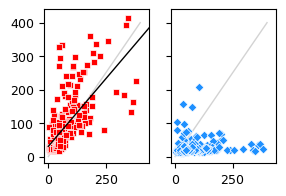

In [141]:
fig, axs = plt.subplots(1,2,figsize=(3,2))

ax = axs[0]
#----------------
x = DF['length_145max'][COND].values
y = DF.cum_drift[COND].values

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)
ax.scatter(x,y,s=20,  facecolor='r', alpha=1,marker='s', lw=0.5, edgecolor='w')

x_line = np.arange(0,500)
y_line = resp.slope*x_line + resp.intercept
ax.plot(x_line, y_line, c='k')

ax.plot([0,400],[0,400], c='lightgray', zorder=-1)


ax = axs[1]
#----------------
x = DF['length_145max'][COND].values
y = DF['X_Pease'][COND].astype(float)

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)

ax.scatter(x,y, s=20, facecolor='dodgerblue', alpha=1, marker='D', lw=0.5, edgecolor='w')

x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept
# ax.plot(x_line, y_line, c='dodgerblue')

for ax in axs:
    ax.set_xlim(-20,440)
    ax.set_ylim(-20,440)
    
axs[1].set_yticklabels([])

ax.plot([0,400],[0,400], c='lightgray', zorder=-1)


In [112]:
0.6771073**2

0.45847429571328996

(-400.0, 400.0)

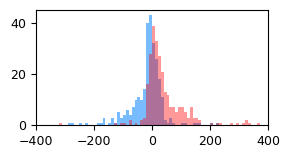

In [106]:
fig, ax = plt.subplots(figsize=(3,1.5))
plt.hist(DF.length_145max[COND].values-DF.cum_drift[COND].values, bins=np.arange(-400,400,10), alpha=0.6, color='dodgerblue')
# ax.axvline(np.nanmedian(DF.length_145max[COND].values-DF.cum_drift[COND].values), c='b')

plt.hist(DF.length_145max[COND].values-XP[COND], bins=np.arange(-400,400,10), alpha=0.4, color='r')

# ax.axvline(np.nanmedian(DF.length_145max[COND].values-XP[COND]), c='r')

ax.set_xlim(-400,400)

# plt.hist(DF.length_145max[COND].values, bins=np.arange(0,500,5))

In [2556]:
np.nanmean(DF.Vi[COND].values)

array([27.90970201])

64.1833469863569

In [2600]:
np.nanmedian(DF.length_145max[COND].values)

44.675539678973095

In [2599]:
np.nanmedian(DF.cum_drift[COND].values)

57.038935363769525

In [2597]:
np.nanmedian(DF.X_Pease[COND].values)

array([19.89632191])

In [2553]:
np.nanstd(DF.X_Pease[COND].values)

array([27.57409146])

In [ ]:
86.2
64.1

In [2068]:
np.nanpercentile(DF.length_145max[COND], 50)

25.238602015648038

In [2069]:
np.nanpercentile(DF.cum_drift[COND], 50)

26.235862426757812

In [2074]:
np.nanpercentile(XP[COND], 50)

20.770552015325013

In [2598]:
np.sum((XP[COND] < 50) & (XP[COND] > 0))/np.sum(COND)

0.9191176470588235

In [2601]:
np.sum((DF.length_145max[COND] > 50) & (DF.length_145max[COND] > 0))/np.sum(COND)

0.44485294117647056

In [2602]:
np.sum((DF.cum_drift[COND] > 50) & (DF.cum_drift[COND] > 0))/np.sum(COND)

0.5735294117647058

In [27]:

# RMSE
#-----
print('RMSE')
print('latent:', np.sqrt(np.nanmean((DF.length_145max[COND].values-XP[COND])**2)))
print('sensible:', np.sqrt(np.nanmean((DF.length_145max[COND].values-DF.cum_drift[COND].values)**2)))
print()
# bias
#-----
print('BIAS')
print('latent:', np.nanmean(XP[COND]-DF.length_145max[COND].values))
print('sensible:', np.nanmean(DF.cum_drift[COND].values-DF.length_145max[COND].values))


RMSE
latent: 82.40873616246425
sensible: 62.390447891063324

BIAS
latent: -40.75151743016083
sensible: 17.494979841417745


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


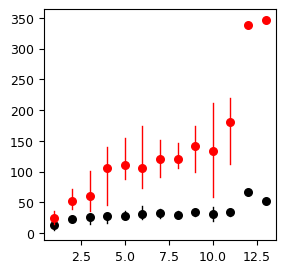

In [28]:
fig, ax = plt.subplots(figsize=(3,3))



# ax.set_ylim(-10,100)
# ax.set_xlim(-10,200)

# ax.scatter(DF.length_145max[COND][:-1], np.diff(DF.length_145max[COND])/DF.Vi[COND][:-1].values, s=5)
# ax.scatter(DF.event_day[COND][:-1], np.diff(DF.length_145max[COND]), s=5)

# ax.scatter(DF.event_day[COND], DF.length_145max[COND], s=5)


# ax.scatter(DF.event_day[COND], DF.width595[COND], s=5)

for dd in range(1,15):

    X = dd
    Y = DF.width595[COND&(DF.event_day==dd)]
    
    ax.scatter(X, np.nanmedian(Y), s=30, c='k')
    ax.plot([X,X], [np.nanpercentile(Y,25),np.nanpercentile(Y,75)], c='k')
    
    
    X = dd
    Y = DF.length_145max[COND&(DF.event_day==dd)]
    
    ax.scatter(X, np.nanmedian(Y), s=30, c='r')
    ax.plot([X,X], [np.nanpercentile(Y,25),np.nanpercentile(Y,75)], c='r')

In [231]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'
# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)


In [269]:

open_thresh=10

map_sic = {}

# for key in list(across.keys())[1::2]:

# for key in ['1','2','3','4','6','8','10','12']:

for key in ['1','4','8','12']:

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(across[key]['date']), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


1


In [271]:
poly_maps = {}
for key in across.keys():
    poly_maps[key] = np.zeros_like(dsic['xx'])
    
total_maps = {}
for key in across.keys():
    total_maps[key] = np.zeros_like(dsic['xx'])
    
for key in ['1','4','8','12']:#list(across.keys())[1::2]:
    
    print(key)
    
    for cdate in across[key]['date']:
    
        YEAR = int(cdate.split('-')[0])
        MONTH = int(cdate.split('-')[1])
        if MONTH == 12:
            YEAR+=1

        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{YEAR}_sic10_v7.6_radius25km.nc') as ds2:

            xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
            yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

            total_maps[key] += 1
            
            for xv, yv in zip(xval, yval):

                dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
                poly_maps[key][np.where(dist == 0)] += 1

1
4
8
12


### era5 maps

In [233]:
# era_map = {}

# for key in ['4','8','12']:
    
#     print(key)
    
#     main_path = "/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily/"

#     ds_list = []

#     yrs = pd.to_datetime(across[key]['date']).year
    
#     for yr in list(set(yrs)):
        
#         if yr!=2025:
#             print(yr)
#             with xr.open_dataset(main_path+f"u10-v10/era5_daily_u10-v10_{yr}.nc") as ds:
#                     ds = ds.sel(latitude=slice(80,66), longitude=slice(-180,-105),
#                                time = across[key]['date'][yrs==yr])
#                     ds_list.append(ds)
#     #         with xr.open_dataset(main_path+f"msl/era5_daily_msl_{yr}.nc") as ds:
#     #                 ds = ds.sel(latitude=slice(80,66), longitude=slice(-180,-105),
#     #                            time = across[key]['date'][yrs==yr])
#     #                 ds_list.append(ds)

#     era_map[key] = xr.concat(ds_list, dim='time')

In [236]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))

# open and crop elevation data
dsg = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n86.8985_s58.3031_w155.8993_e278.1175.nc')
dsg = dsg.sel(lon = slice(207, 230), lat = slice(69.35,71.6))
g1, g2 = np.gradient(dsg.elevation.values)
depth_gradient = np.sqrt(g1**2+g2**2)

1
4
8
12


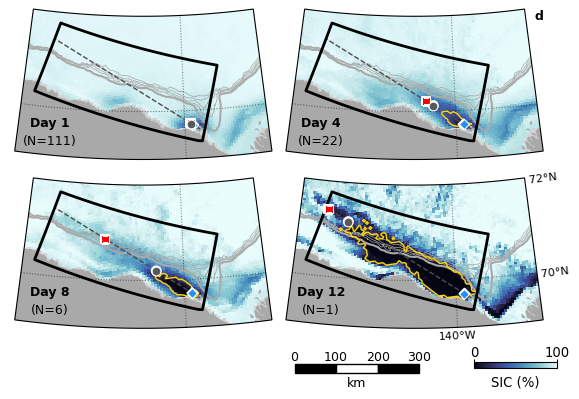

In [274]:
from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]

from pyproj import Geod
g = Geod(ellps='WGS84')

startlon, startlat = -139.1, 69.6

from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]


# grab box border
clip_path_small = fn.create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(2,2,figsize=(7,4.5), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs.ravel()):
    
    ax.patch.set_facecolor('lightgray')

    ax.set_boundary(clip_path_small, transform=proj)
    ax.set_extent([lon_range_small[0], lon_range_small[1], 
                   lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
#     ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#                colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


    gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
    gl.xlocator = FixedLocator([ -140])
    gl.ylocator = FixedLocator([70])
    gl.bottom_labels = False
    gl.right_labels = False

    if ax == axs.ravel()[-1]: 
        for lat in [70,72]:
            rot = -135-(-142.5)
            ax.text(-135, lat, f" {lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='center', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-140]:
            rot = lon-(-142.5)
            ax.text(lon, 68.95, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)
            
            
for n, key in enumerate(['1','4','8','12']):#list(across.keys())[1::2]):
    
    print(key)

    ax = axs.ravel()[n]
    
    ax.text(0.15,0.325,f'Day {key}', weight='bold', ha='center', va='bottom', transform=ax.transAxes)#, size=FS)
    ax.text(0.15,0.225,f'(N={len(across[key]['date'])})', ha='center', va='bottom', transform=ax.transAxes)#, size=FS)
    
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    # Open water frequency
    #---------------------
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'], zorder=0)
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#               vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 100*poly_maps[key]/total_maps[key],#100*map_sic[key]['open_freq'], 
              levels=[50], colors=['gold'], transform=dsic['proj'], zorder=99)

    # dashed line
    #------------
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    # markers
    #------------
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ 'dodgerblue', 'r', [0.35]*3], 
                                       [ 'white', 'white', 'white'], 
                                       ['D','s', 'o'], [25, 35, 40], [0.75,0.75,0.75]):
    
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=1.5, zorder=101)
    
    
# atmosphere
#-----------
# for ax, key in zip(axs[:], [ '4', '8', '12']):

#     print(key)
    
#     # sea level press
#     #----------------
# #     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
# #                        era_map[key]['msl'][::sp,::sp]/100, 
# #                        vmin=1012,vmax=1028, 
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
# #     mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
# #                        era_map[key]['msl'].mean('time')/100, 
# #                        vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

#     # winds
#     #----------------
#     longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
#     u1 = era_map[key]['u10'].mean('time').values
#     v1 = era_map[key]['v10'].mean('time').values
#     U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
#     sp1, sp2 = 3,6
#     Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
#                   U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0002, width=0.01, headwidth=4,headlength=4, headaxislength=4, 
#                   color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    
ax = axs.ravel()[1]
ax.text(0.95,1, f'd', weight='bold', 
            ha='left', va='top', transform=ax.transAxes)
    
ax = axs.ravel()[-1]
plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.0125, cb_length_fraction=[0.7, 1.05], cb_pad=0.015, cb_ticks=[0,100], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad=5,#-10, 
                     cb_label_placement='bottom', cb_tick_placement='top', tick_kwargs={'pad':0.1, 'length':2},#, 'length':0, 'labelsize':40, 'length':0.1, 'width':4}, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(ax, loc=(0.05, -0.1), steps=[100,200,300],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)


plt.subplots_adjust(hspace=-0.05, wspace=0 )
    
SAVE(fig, '/Users/mackenziejewell/Desktop/map_panels.png')

1
4
8
12


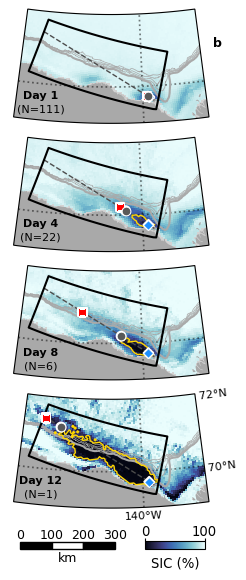

In [345]:
from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]

from pyproj import Geod
g = Geod(ellps='WGS84')

startlon, startlat = -139.1, 69.6

from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]


# grab box border
clip_path_small = fn.create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(4,1,figsize=(3.5,6.75), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs):#.ravel()):
    
    ax.patch.set_facecolor('lightgray')

    ax.set_boundary(clip_path_small, transform=proj)
    ax.set_extent([lon_range_small[0], lon_range_small[1], 
                   lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
#     ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#                colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


    gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=1.25, color='k', alpha=0.5, linestyle='dotted')
    gl.xlocator = FixedLocator([ -140])
    gl.ylocator = FixedLocator([70])
    gl.bottom_labels = False
    gl.right_labels = False

    if ax == axs.ravel()[-1]: 
        for lat in [70,72]:
            rot = -135-(-142.5)
            ax.text(-135, lat, f" {lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='center', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-140]:
            rot = lon-(-142.5)
            ax.text(lon, 68.95, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)
            
            
for n, key in enumerate(['1','4','8','12']):#list(across.keys())[1::2]):
    
    print(key)

    ax = axs.ravel()[n]
    
    ax.text(0.15,0.325,f'Day {key}', weight='bold', ha='center', va='bottom', size=8, transform=ax.transAxes)#, size=FS)
    ax.text(0.15,0.225,f'(N={len(across[key]['date'])})', ha='center', va='bottom',size=8,  transform=ax.transAxes)#, size=FS)
    
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    # Open water frequency
    #---------------------
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'], zorder=0)
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#               vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 100*poly_maps[key]/total_maps[key],#100*map_sic[key]['open_freq'], 
              levels=[50], colors=['gold'], transform=dsic['proj'], zorder=99)

    # dashed line
    #------------
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    # markers
    #------------
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ 'dodgerblue', 'r', [0.35]*3], 
                                       [ 'white', 'white', 'white'], 
                                       ['D','s', 'o'], [25, 35, 40], [0.75,0.75,0.75]):
    
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=1.5, zorder=101)
    
    
# atmosphere
#-----------
# for ax, key in zip(axs[:], [ '4', '8', '12']):

#     print(key)
    
#     # sea level press
#     #----------------
# #     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
# #                        era_map[key]['msl'][::sp,::sp]/100, 
# #                        vmin=1012,vmax=1028, 
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
# #     mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
# #                        era_map[key]['msl'].mean('time')/100, 
# #                        vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
# #                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

#     # winds
#     #----------------
#     longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
#     u1 = era_map[key]['u10'].mean('time').values
#     v1 = era_map[key]['v10'].mean('time').values
#     U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
#     sp1, sp2 = 3,6
#     Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
#                   U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0002, width=0.01, headwidth=4,headlength=4, headaxislength=4, 
#                   color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    
ax = axs[0]
ax.text(1,0.8, f'b', weight='bold', 
            ha='left', va='top', transform=ax.transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.0125, cb_length_fraction=[0.7, 1.05], cb_pad=0.015+0.0025, cb_ticks=[0,100], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad=5,#-10, 
                     cb_label_placement='bottom', cb_tick_placement='top', tick_kwargs={'pad':0.1, 'length':2},#, 'length':0, 'labelsize':40, 'length':0.1, 'width':4}, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-1], loc=(0.05, -0.15), steps=[100,200,300],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)


plt.subplots_adjust(hspace=-0.05, )
    
SAVE(fig, '/Users/mackenziejewell/Desktop/map_panels.png')

# Version 2
For each strong east wind event coinciding with an MCP event, start "event" from first day of observed polynya opening. Progress in time until wind event ends (allowing polynya to close beforeso). Turns out pretty much the same which suggests similar approach above ^ is representative of polynya growth generally.

In [29]:

all_yrs = []
all_lens = []

dates = {}
record = {}

categories = ['length_145max', 'X_Pease', 't95', 'Fi', 'cum_drift_once_open']
L = 13

for cat in categories:
    record[cat] = {}
    for dd in range(1, L+1):
        record[cat][dd] = np.array([])
        
for dd in range(1, L+1):
    dates[dd] = np.array([])


#============
DF = dfr
#============  
   
wind_sequences = list(set(DF.wind_seq[(DF.wind_seq!=-999)]))


for ww in wind_sequences:

    select = (DF.wind_seq == ww)&(DF.polynya_has_opened)
    
    for cat in categories:
        
        values = DF[select][cat].values
        datess = DF[select]['time'].values
        defined_Pease = DF[select]['t95'].values < 15 * units('day')
        substitute = DF[select]['cum_drift_once_open'].values

        if cat == 'X_Pease':
            for ii, vv, defined, sub in zip(range(len(values)), values, defined_Pease, substitute):
                if defined:
                    record[cat][ii+1] = np.append(record[cat][ii+1], vv.magnitude)
                else:
                    record[cat][ii+1] = np.append(record[cat][ii+1], sub)

        elif cat == 'time':
            for ii, vv in enumerate(datess):
                dates[ii+1] = np.append(dates[ii+1], vv)
        
        else:
            for ii, vv in zip(range(len(values)), values):
                record[cat][ii+1] = np.append(record[cat][ii+1], vv)

    
#     plt.scatter(range(len(DF['extent'].values[ss[0]:ss[1]])), DF['extent'].values[ss[0]:ss[1]])

In [30]:

byday = {}

percents = [5,10,25,50,75,90,95]
also = ['avg', 'std', 'avg_ms', 'avg_ps']

x_values = np.array(list(set(record[cat].keys())))

for cat in record.keys():
    
    byday[cat] = {}
    
    for per in percents:
        byday[cat][per] = np.array([])
        
        for dd in x_values:
            byday[cat][per] = np.append(byday[cat][per], np.nanpercentile(record[cat][dd], per))
        
    for per in also:
        byday[cat][per] = np.array([])
        
        
counts_by_day = np.array([])   
for dd in x_values:
    counts_by_day = np.append(counts_by_day, len(record[cat][dd]))


In [31]:
all_values = {}

for cat in record.keys():
    all_values[cat] = np.array([])
    for dd in x_values:
        all_values[cat] = np.append(all_values[cat], record[cat][dd])
        
all_values['day'] = np.array([]) 
for dd in x_values:
    all_values['day'] = np.append(all_values['day'], np.full(len(record[cat][dd]), dd))

<>:96: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_44586/3697461740.py:96: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


37.980427843301314 64.58043679567001
-16.854233452850654 65.08112529292944


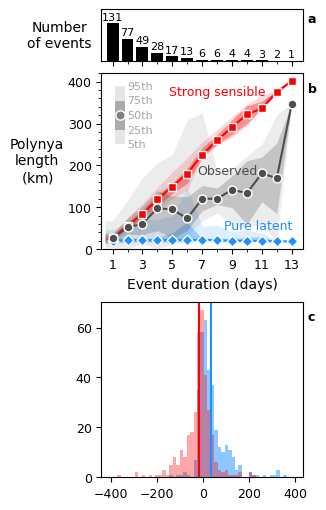

In [33]:
fig, axs = plt.subplots(3,1,figsize=(2.6,6.5), gridspec_kw={'height_ratios':[0.25,1,1]})


    
color1 = 'k'#[50/255,115/255, 255/255]   
color2 = 'darkgray'# [137/255,173/255, 255/255]   
    
    
ax = axs[0]
ax.set_ylim(0,180)
ax.set_yticks([])
ax.set_ylabel('Number\nof events', rotation=0, labelpad=30, va='center')
ax.bar(x_values, counts_by_day, color=color1)
for dd, count in zip(x_values, counts_by_day):
    ax.text(dd, count+5, int(count), 
            color=color1, va='bottom', ha='center', size=8)


ax = axs[1]

weight = 'normal'
ax.text(0.575,0.875,'Strong sensible', ha='center', weight=weight, c='r', transform=ax.transAxes)
ax.text(0.95,0.11,'Pure latent', ha='right', weight=weight, c='dodgerblue', transform=ax.transAxes)
ax.text(0.775,0.425, 'Observed', ha='right', weight=weight, c=[0.3]*3, transform=ax.transAxes)

bff = 0.5

for key, color, marker, size, alpha1, alpha2 in zip(['X_Pease', 
                               'cum_drift_once_open', 
                               'length_145max',], 
                      ['dodgerblue', 'r', [0.3]*3], ['D', 's', 'o'], [30,30,40], [0.35,0.35,0.25], [0.15,0.15,0.1]):
    
    ax.scatter(x_values+lo, byday[key][50], lw=1, edgecolor='white', marker=marker, s=size,facecolor=color, zorder=100)
    ax.plot(x_values+lo, byday[key][50], lw=1.5, c=color, ls='solid',   zorder=99)


    X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
    Y1_exp = np.concatenate((np.array([byday[key][25][0]]), byday[key][25], np.array([byday[key][25][-1]])))
    Y2_exp = np.concatenate((np.array([byday[key][75][0]]), byday[key][75], np.array([byday[key][75][-1]])))
    
    ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=alpha1, color=color, lw=0 ,zorder=-4)
    
    
    X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
    Y1_exp = np.concatenate((np.array([byday[key][5][0]]), byday[key][5], np.array([byday[key][5][-1]])))
    Y2_exp = np.concatenate((np.array([byday[key][95][0]]), byday[key][95], np.array([byday[key][95][-1]])))
    ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=alpha2, color=color, lw=0 ,zorder=-4)
    
    
    
# label the percentiles
#----------------------
    
xxx = 1.5
ax.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45,facecolor='gray', zorder=100)

X_exp = np.linspace(xxx-0.35,xxx+0.35, 3)
Y1_exp = np.full(3, 285)
Y2_exp = np.full(3, 355)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.25, color='k', lw=0 ,zorder=-6)
Y1_exp = np.full(3, 250)
Y2_exp = np.full(3, 390)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.1, color='k', lw=0 ,zorder=-6)

color = [0.65]*3
ax.text(xxx+0.5,320, '50th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,355, '75th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,390, '95th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,285, '25th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,250, '5th', ha='left', va='center', c=color, size=8)



    
axs[0].set_xticklabels([])
axs[1].set_xlabel('Event duration (days)')

for aa, ax in enumerate(axs):
    ax.text(1.025, 0.95, f'{chr(97+aa)}', 
            ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
  
for ax in axs[:-1]:
    ax.set_xlim(0.25,x_values.max()+.75)
    ax.xaxis.set_major_locator(ticker.FixedLocator([1,3,5,7,9,11,13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    


plt.subplots_adjust(hspace=0.4)

ax = axs[1]
ax.set_ylim(0,420)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')

axs[0].set_position([0.125, 0.75, 0.775, 0.08])
    
    
ax = axs[2]

vals1 = (all_values['length_145max'] - all_values['X_Pease'])#[all_values['day']>2],
ax.hist(vals1,
        bins=np.arange(-400,400,15), 
        color='dodgerblue', alpha=0.5)
plt.axvline(np.nanmean(vals1), c='dodgerblue', lw=1.5)

vals2 = (all_values['length_145max'] - all_values['cum_drift_once_open'])#[all_values['day']>2]
ax.hist(vals2, 
        bins=np.arange(-400,400,15), 
        color='r', alpha=0.35)
plt.axvline(np.nanmean(vals2), c='r', lw=1.5)
# ax.set_xlim(-200,200)


print(np.nanmean(vals1), np.nanstd(vals1))
print(np.nanmean(vals2), np.nanstd(vals2))

fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')

In [1458]:
np.sqrt(np.nanmean((vals1)**2))

74.92092975851105

In [1457]:
np.sqrt(np.nanmean((vals2)**2))

67.2281046488533

In [1441]:
all_values['day']>1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
x = all_values['cum_drift_once_open']
y = all_values['length_145max']

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)

ax.scatter(x, y, s=20, edgecolor='r',marker='s', facecolor='None', lw=1, alpha=0.8, zorder=1)
x_line = np.arange(0,400)
y_line = resp.slope*x_line + resp.intercept

ax.plot(x_line,y_line)

x = all_values['X_Pease']
y = all_values['length_145max']

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)

ax.scatter(x,y, s=20, edgecolor='dodgerblue',marker='D', facecolor='None', lw=1, alpha=0.8, zorder=1)
x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept

# ax.plot(x_line,y_line)

ax.set_xlim(-20,420)
ax.set_ylim(-20,420)

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))


In [1424]:
0.5821246066**2

0.33886905760920477

In [1422]:
np.nansum(all_values['X_Pease'] < 50)/len(all_values['X_Pease'] < 50)

0.9178885630498533

In [1409]:
np.nanmedian(all_values['length_145max'] - all_values['cum_drift_once_open'])

-9.573458673169398

In [1410]:
np.nanmedian(all_values['length_145max'] - all_values['X_Pease'])

20.527666986266023

In [1365]:
axs[1].get_position()

Bbox([[0.125, 0.4612280701754386], [0.9, 0.7314035087719298]])

In [1358]:
axs[0].get_position()

Bbox([[0.125, 0.8124561403508772], [0.9, 0.88]])

In [ ]:



wi = 0.2
hi = 8

bff = 0.35
lo = 0

weight='normal'


ax = axs[1]

#-----------------
category = pred_pers
color = 'r'

ax.text(0.575,0.875,'Strong sensible', ha='center', weight=weight, c=color, transform=ax.transAxes)

ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='s', s=40,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)


# ax.plot(x_values+lo, category[10], lw=0.5, c=color, ls='dashed',   zorder=99)
# ax.plot(x_values+lo, category[90], lw=0.5, c=color, ls='dashed',   zorder=99)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))

# Y1_exp = np.concatenate((np.array([category[10][0]]), category[10], np.array([category[10][-1]])))
# Y2_exp = np.concatenate((np.array([category[90][0]]), category[90], np.array([category[90][-1]])))

# Y1_exp = np.concatenate((np.array([category['avg_ms'][0]]), category['avg_ms'], np.array([category['avg_ms'][-1]])))
# Y2_exp = np.concatenate((np.array([category['avg_ps'][0]]), category['avg_ps'], np.array([category['avg_ps'][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.35, color=color, lw=0 ,zorder=-4)


Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-6)

    
#-----------------

category = lat_pers
color = 'dodgerblue'
ax.text(0.95,0.11,'Pure latent', ha='right', weight=weight, c=color, transform=ax.transAxes)


ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='D', s=35,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.3, color=color, lw=0 ,zorder=-4)

Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-6)

    

#-----------------
category = obs_pers
color = [0.3]*3

ax.text(0.775,0.425, 'Observed', ha='right', weight=weight, c=color, transform=ax.transAxes)


ax.scatter(x_values+lo, category[50], lw=1, edgecolor='white', marker='o', s=45,facecolor=color, zorder=100)
ax.plot(x_values+lo, category[50], lw=1.5, c=color, ls='solid',   zorder=99)


# ax.plot(x_values+lo, category[10], lw=0.5, c=color, ls='dashed',   zorder=99)
# ax.plot(x_values+lo, category[90], lw=0.5, c=color, ls='dashed',   zorder=99)


# ax.plot(x_values, category[25],alpha=1, color=color, lw=0.5, ls='dashed', zorder=-4)
# ax.plot(x_values, category[75],alpha=1, color=color, lw=0.5, ls='dashed', zorder=-4)

# ax.fill_between(x_values, category[25], category[75], alpha=0.25, color=color, lw=0 ,zorder=-4)

X_exp = np.concatenate((np.array([x_values.min()-bff]), x_values, np.array([x_values.max()+bff])))
Y1_exp = np.concatenate((np.array([category[25][0]]), category[25], np.array([category[25][-1]])))
Y2_exp = np.concatenate((np.array([category[75][0]]), category[75], np.array([category[75][-1]])))

# Y1_exp = np.concatenate((np.array([category[10][0]]), category[10], np.array([category[10][-1]])))
# Y2_exp = np.concatenate((np.array([category[90][0]]), category[90], np.array([category[90][-1]])))


# Y1_exp = np.concatenate((np.array([category['avg_ms'][0]]), category['avg_ms'], np.array([category['avg_ms'][-1]])))
# Y2_exp = np.concatenate((np.array([category['avg_ps'][0]]), category['avg_ps'], np.array([category['avg_ps'][-1]])))


ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.2, color=color, lw=0 ,zorder=-4)

Y1_exp = np.concatenate((np.array([category[5][0]]), category[5], np.array([category[5][-1]])))
Y2_exp = np.concatenate((np.array([category[95][0]]), category[95], np.array([category[95][-1]])))
ax.fill_between(X_exp,Y1_exp,  Y2_exp, alpha=0.1, color=color, lw=0 ,zorder=-6)


    
# Get the y-axis tick labels
xtick_labels = axs[1].get_xticklabels()

axs[0].set_xlabel('Event duration (days)')
axs[1].set_xlabel('Event duration (days)')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 1.025, f'{chr(97+aa)}', 
                ha='right', va='bottom', weight='bold', clip_on=False, transform = ax.transAxes)
    else:
        ax.text(0.975, 1.01, f'{chr(97+aa)}', 
                ha='right', va='bottom', weight='bold', clip_on=False, transform = ax.transAxes)

    


# for dd in x_values:
#     ax.axvline(dd, c='lightgray', lw=0.5, zorder=-100)
# for dd in [100,200,300]:
#     ax.axhline(dd, c='lightgray', lw=0.5, zorder=-100)
    
for ax in axs[:-1]:
    ax.set_xlim(0.35,x_values.max()+.5)
    ax.xaxis.set_major_locator(ticker.FixedLocator([1,3,5,7,9,11,13]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    

# for ax in axs[2:2]:
#     ax.set_ylim(0,1.05)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
#     ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


ax = axs[1]
ax.set_ylim(0,420)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.set_ylabel('Polynya\nlength\n($\mathrm{km}$)', rotation=0, labelpad=22, va='center')


xxx = 1.5
ax.scatter(xxx, 320, lw=1, edgecolor='white', marker='o', s=45,facecolor='gray', zorder=100)

X_exp = np.linspace(xxx-0.35,xxx+0.35, 3)
Y1_exp = np.full(3, 285)
Y2_exp = np.full(3, 355)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.25, color='k', lw=0 ,zorder=-6)
Y1_exp = np.full(3, 250)
Y2_exp = np.full(3, 390)
ax.fill_between(X_exp, Y1_exp,  Y2_exp, alpha=0.1, color='k', lw=0 ,zorder=-6)


color = [0.65]*3
ax.text(xxx+0.5,320, '50th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,355, '75th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,390, '95th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,285, '25th', ha='left', va='center', c=color, size=8)
ax.text(xxx+0.5,250, '5th', ha='left', va='center', c=color, size=8)





ax = axs[2]
ax.set_xlim(-20,420)
ax.set_ylim(-20,420)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))

XP = np.array([L.magnitude.item() for L in DF.X_Pease.values])
XP_num = np.array([L.magnitude.item() for L in DF.X_Pease_num.values])

# shoulder = ((DF['season_start_flag'])) #+ (east_maint==False)# + DF['season_end_flag']))# + DF['final_day'])

COND = ((DF.length_145max>0) & (event_cond)) #& ((DF.event_day >=5)) #& (DF.sequence!=150)
# COND = ((DF.length_145max>0) & (shoulder==False) ) #&(DF.event_day > 2) # & ((east_maint))
# COND = ((DF.event_day > 2)& (shoulder==False) )

# COND = ((DF.length_145max>0) & (event_cond)) & (east_maint)
# COND = ((DF.length_145max>0) & (DF['season_start_flag']==False)) #& (DF.event_day == 3)


#----------------
x = XP[COND]
y = DF['length_145max'][COND].values

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)

# ax.scatter(x,y, s=20, c='dodgerblue',marker='D', lw=0.5, edgecolor='w')

ax.scatter(x,y, s=20, edgecolor='dodgerblue',marker='D', facecolor='None', lw=1, alpha=0.8, zorder=1)

x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept
# ax.plot(x_line, y_line, c='dodgerblue')

#----------------
x = DF.cum_drift[COND].values
y = DF['length_145max'][COND].values

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)
ax.scatter(x,y,s=20, edgecolor='r',marker='s',  facecolor='None', lw=1,alpha=0.8,  zorder=0)

x_line = np.arange(0,500)
y_line = resp.slope*x_line + resp.intercept
ax.plot(x_line, y_line, c='k')




plt.subplots_adjust(hspace=0.4)


# ax.plot(x_values[2:-4], np.linspace(0,200,len(x_values[2:-4])))
# fig.savefig('../figures/results/comp_time_v2.png', dpi=400, bbox_inches='tight')

fig.savefig('/Users/mackenziejewell/Desktop/timeseries_v2.png', dpi=400, bbox_inches='tight')

In [1298]:
for dd in record[cat].keys():
    
    dd

In [1299]:
dd

20

In [1300]:
record[cat][dd]

array([], dtype=float64)

In [ ]:
lat_pers[per] = np.append(lat_pers[per], np.nanpercentile(DF[VAR][cond], per))

In [1293]:
record.keys()

dict_keys(['length_145max', 'X_Pease', 't95', 'Fi', 'cum_drift_once_open'])

In [ ]:
df

In [ ]:

percents = [5,10,25,50,75,90,95]
also = ['avg', 'std', 'avg_ms', 'avg_ps']

#----------------------
VAR = 'X_Pease'
lat_pers = {}
for per in percents:
    lat_pers[per] = np.array([])
for per in also:
    lat_pers[per] = np.array([])
    
for dd, cond in zip(x_values, all_cond):
    for per in percents:
        lat_pers[per] = np.append(lat_pers[per], np.nanpercentile(DF[VAR][cond], per))
    lat_pers['avg'] = np.append(lat_pers['avg'], np.nanmean(DF[VAR][cond]))
    lat_pers['std'] = np.append(lat_pers['std'], np.nanstd(DF[VAR][cond]))
    
    lat_pers['avg_ms'] = np.append(lat_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    lat_pers['avg_ps'] = np.append(lat_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))
        
        
#----------------------        
VAR = 'length_145max'
# VAR = 'width'
obs_pers = {}
for per in percents:
    obs_pers[per] = np.array([])
for per in also:
    obs_pers[per] = np.array([])
    
for dd, cond in zip(x_values, all_cond):
    for per in percents:
        obs_pers[per] = np.append(obs_pers[per], np.nanpercentile(DF[VAR][cond], per))
    obs_pers['avg'] = np.append(obs_pers['avg'], np.nanmean(DF[VAR][cond]))
    obs_pers['std'] = np.append(obs_pers['std'], np.nanstd(DF[VAR][cond]))
    
    obs_pers['avg_ms'] = np.append(obs_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    obs_pers['avg_ps'] = np.append(obs_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))
        
    
#----------------------        
VAR = 'cum_drift'
pred_pers = {}
for per in percents:
    pred_pers[per] = np.array([])
for per in also:
    pred_pers[per] = np.array([])

for dd, cond in zip(x_values, all_cond):
    for per in percents:
        pred_pers[per] = np.append(pred_pers[per], np.nanpercentile(DF[VAR][cond], per))
    pred_pers['avg'] = np.append(pred_pers['avg'], np.nanmean(DF[VAR][cond]))
    pred_pers['std'] = np.append(pred_pers['std'], np.nanstd(DF[VAR][cond]))
    
    pred_pers['avg_ms'] = np.append(pred_pers['avg_ms'], np.nanmean(DF[VAR][cond]) - np.nanstd(DF[VAR][cond]))
    pred_pers['avg_ps'] = np.append(pred_pers['avg_ps'], np.nanmean(DF[VAR][cond]) + np.nanstd(DF[VAR][cond]))

In [ ]:
    
#     # grab event indices
#     event_indices = (DF[DF.wind_seq == ww]).index

#     # determine if polynya opens
#     # if so, start event from when it opens
#     is_open = np.where(DF[DF.wind_seq == ww].extent>0)[0]
#     if len(is_open)>0:
        
#         # grab values beginning as and after polynya opens
# #         DF.loc[event_indices[is_open[0]:]]
        
#         for cat in categories:
#             values = DF.loc[event_indices[is_open[0]:]][cat].values
#             datess = DF.loc[event_indices[is_open[0]:]]['time'].values

#             for ii, vv in enumerate(values):
#                 lengths[cat][ii+1] = np.append(lengths[cat][ii+1], vv)

#             if cat == categories[-1]:
#                 for ii, vv in enumerate(datess):
#                     dates[ii+1] = np.append(dates[ii+1], vv)

#         did_open+=1
#         did_open_lengths.append(np.sum(DF.wind_seq == ww))
#         did_open_starts.append(is_open[0]+1)
        
        
#     else:
#         never_opened += 1
#         never_opened_lengths.append(np.sum(DF.wind_seq == ww))
        
        
        
        
    
#     if np.sum(df[df.wind_seq == ss].extent.values[:2] > 0)>=1:

In [1274]:
all_cum_drift = np.array([])
all_observed = np.array([])
all_latent = np.array([])
all_times = np.array([])
all_fi = np.array([])

for dd in lengths[cat].keys():
    
    years = pd.to_datetime(dates[dd]).year
    
    if len(lengths[cat][dd]) > 0:

        cat = 'cum_drift_once_open'
        all_cum_drift = np.append(all_cum_drift, lengths[cat][dd])#[years>=2016])

        cat = 'length_145max'
        all_observed = np.append(all_observed, lengths[cat][dd])#[years>=2016])

        cat = 'X_Pease'
    #     all_latent = np.append(all_latent, lengths[cat][dd])#[years>=2016])
        all_latent = np.append(all_latent,np.where(lengths['t95'][dd]<7*units('day'), 
                              lengths[cat][dd].magnitude, 
                              lengths['cum_drift_once_open'][dd]))

        cat = 't95'
        all_times = np.append(all_times, lengths[cat][dd])#[years>=2016])

        cat = 'Fi'
        all_fi = np.append(all_fi, lengths[cat][dd])#[years>=2016])

In [ ]:
np.isfinite(lengths['t95'][dd])

In [1272]:
all_times[all_latent>600]

Magnitude,[74.11264423184925]
Units,day


In [1262]:
len(all_latent)

341

LinregressResult(slope=0.4982829913333007, intercept=23.99518245995744, rvalue=0.5821246066315146, pvalue=2.557302022211128e-32, stderr=0.03780106173119776, intercept_stderr=4.206453258417849)
0.33886905764589553
LinregressResult(slope=0.693363930213553, intercept=46.21947161060146, rvalue=0.21879462059566326, pvalue=4.602510715807725e-05, stderr=0.16794714795661, intercept_stderr=5.620217107742154)
0.047871086001600234


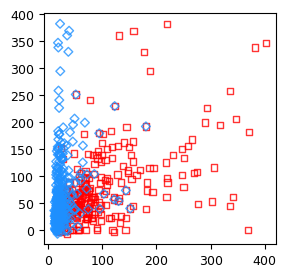

In [1288]:
fig, ax = plt.subplots(figsize=(3,3,))



x = all_cum_drift
y = all_observed
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)
print(resp.rvalue**2)

ax.scatter(x,y, s=20, edgecolor='r',marker='s', facecolor='None', lw=1, alpha=0.8, zorder=1)

x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept





x = all_latent
y = all_observed
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

resp = stats.linregress(x_nn,y_nn)
print(resp)
print(resp.rvalue**2)

ax.scatter(x,y, s=20, edgecolor='dodgerblue',marker='D', facecolor='None', lw=1, alpha=0.8, zorder=1)

x_line = np.arange(0,200)
y_line = resp.slope*x_line + resp.intercept



# ax.set_xlim(-20,420)
# ax.set_ylim(-20,420)

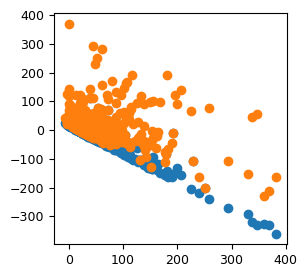

In [1276]:
fig, ax = plt.subplots(figsize=(3,3,))


# plt.hist(all_latent.magnitude - all_observed, bins=np.arange(-400,400,15), alpha=0.5, color='dodgerblue')
# ax.axvline(np.nanmean(all_latent.magnitude - all_observed), c='dodgerblue')
# print(np.nanmean(all_latent.magnitude - all_observed))

# plt.hist(all_cum_drift - all_observed, bins=np.arange(-400,400,15), alpha=0.5, color='r')
# ax.axvline(np.nanmean(all_cum_drift - all_observed), c='r')
# print(np.nanmean(all_cum_drift - all_observed))


plt.scatter(all_observed, all_latent - all_observed)
plt.scatter(all_observed, all_cum_drift - all_observed)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21223/691281695.py:13: RuntimeWarning: invalid value encountered in scalar divide
  ax.scatter(dd, np.sum(lengths['length_145max'][dd]>0)/len(lengths['length_145max'][dd]))


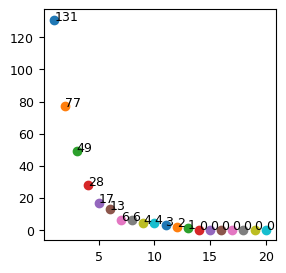

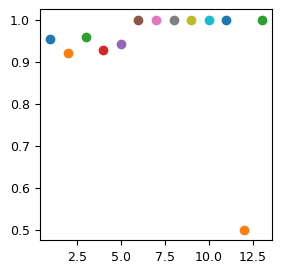

In [1277]:
fig, ax = plt.subplots(figsize=(3,3,))

for dd in lengths[cat].keys():
    
    ax.scatter(dd, len(lengths[cat][dd]))
    
    ax.text(dd, len(lengths[cat][dd]), len(lengths[cat][dd]))
  
fig, ax = plt.subplots(figsize=(3,3,))

for dd in lengths['length_145max'].keys():
    
    ax.scatter(dd, np.sum(lengths['length_145max'][dd]>0)/len(lengths['length_145max'][dd]))

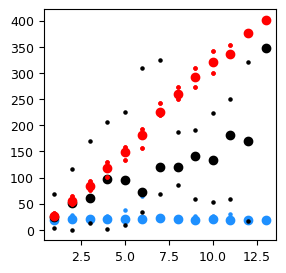

In [1289]:
fig, ax = plt.subplots(figsize=(3,3,))

for dd in lengths[cat].keys():
    
    if dd < 14:
        years = pd.to_datetime(dates[dd]).year

    #     ax.scatter(dd, len(lengths[cat][dd]))

        cat = 'X_Pease'
        ax.scatter(dd, np.nanmedian(record[cat][dd]), c='dodgerblue')
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 25), c='dodgerblue', s=5)
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 75), c='dodgerblue', s=5)

        cat = 'length_145max'
        ax.scatter(dd, np.nanmedian(record[cat][dd]), c='k')
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 5), c='k', s=5)
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 95), c='k', s=5)

        cat = 'cum_drift_once_open'
        ax.scatter(dd, np.nanmedian(record[cat][dd]), c='r')
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 25), c='r', s=5)
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 75), c='r', s=5)
        
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 25), c='r', s=5)
        ax.scatter(dd, np.nanpercentile(record[cat][dd], 75), c='r', s=5)

#     ax.scatter(dd, np.sum(lengths_by_day[dd]>0)/len(lengths_by_day[dd]))

In [ ]:
fig, ax = plt.subplots(figsize=(3,1.5))
plt.hist(DF.length_145max[COND].values-DF.cum_drift[COND].values, bins=np.arange(-400,400,10), alpha=0.6, color='dodgerblue')
# ax.axvline(np.nanmedian(DF.length_145max[COND].values-DF.cum_drift[COND].values), c='b')

plt.hist(DF.length_145max[COND].values-XP[COND], bins=np.arange(-400,400,10), alpha=0.4, color='r')


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21223/448750715.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22.39475729]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.wind_seq == ss, 'cum_drift_wind'] = np.cumsum(df.loc[df.wind_seq == ss, 'ese10']).values


In [334]:
df.loc[df.wind_seq == ss, 'cum_drift'] = np.cumsum(df.loc[df.wind_seq == ss, 'ese10']).values

array([22.04930347, 50.6644519 ])

In [318]:
df.loc[df.index == df.index.values[sss], 'wind_seq'] = ii

In [331]:
df[df.wind_seq == 422];

In [ ]:

for ss in wind_seqs:
    for ii, sss in enumerate(np.arange(ss[0],ss[1])):
        

seqs = np.array(list(set(df.sequence[df.sequence!=-999])))

for ss in seqs:
    df.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(df.loc[df.sequence == ss, 'ese10']).values
    

In [ ]:

for ss in wind_seqs:
    

    for ii, sss in enumerate(np.arange(ss[0],ss[1])):

In [237]:
ss

(3473, 3475)

In [239]:
np.arange(ss[0],ss[1])

array([3473, 3474])

In [230]:
DF['extent'].values[ss[0]:ss[1]]

array([0., 0.])

In [ ]:
DF['time'].values[ss[0]:ss[1]]

In [225]:
ss

(3473, 3475)

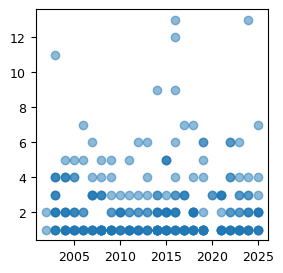

In [224]:
fig, ax = plt.subplots(figsize=(3,3))

plt.scatter(all_yrs, all_lens, alpha=0.5)

(2002.0, 2026.0)

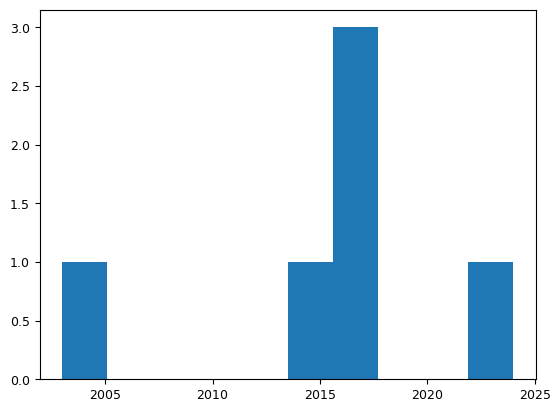

In [217]:
yrs = pd.to_datetime(across['7']['date']).year

plt.hist(yrs)

ax.set_xlim(2002,2026)

In [ ]:
across

In [37]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))

# open and crop elevation data
dsg = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n86.8985_s58.3031_w155.8993_e278.1175.nc')
dsg = dsg.sel(lon = slice(207, 230), lat = slice(69.35,71.6))
g1, g2 = np.gradient(dsg.elevation.values)
depth_gradient = np.sqrt(g1**2+g2**2)

In [2273]:
list(across.keys())[2:-2]

['3', '4', '5', '6', '7', '8']

In [87]:
obs_pers[50]

array([ 24.25937948,  52.40683344,  60.30576303, 104.24992744,
       110.8809336 , 105.60694255, 120.11718136, 120.10424162,
       141.65455632, 133.70643028, 180.95356662, 338.19436769,
       346.99149169])

4
7


KeyError: '7'

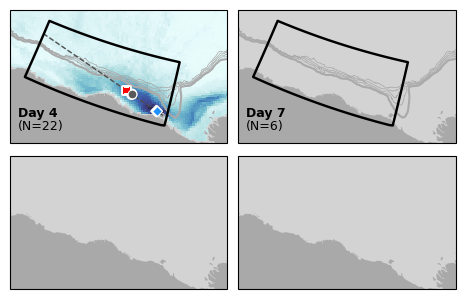

In [245]:
fig, axs = fn.makemap(view='wider_zoom4', contours = [], 
                      panels=(2,2), figsize=(5.75,3.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10
# iced = np.array([50.82842169,  68.58080734,  90.47338417,
#         98.24958483, 120.57204264, 128.47181612])
wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]


bearing = -55

FS = 10

# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
# for key, n in zip([f'{m}' for m in [1,3,5,7,9]]+[f'10+'],
#                      range(6)):

# +['10+']
for key, n in zip([f'{m}' for m in [4,7,10,13]],
                     range(4)):
    
    print(key)

#     axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
#                 ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    
    
    ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key}', weight='bold', ha='left', va='bottom', transform=ax.transAxes)#, size=FS)
    ax.text(0.035,0.075,f'(N={len(across[key]['date'])})', ha='left', va='bottom', transform=ax.transAxes)#, size=FS)
    
    
    # Open water frequency
    #-----------
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#               vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)

    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'], zorder=0)

    # dashed line
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    
    
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ 'dodgerblue', 'r', [0.35]*3], 
                                       [ 'white', 'white', 'white'], 
                                       ['D','s', 'o'], [25, 35, 40], [0.75,0.75,0.75]):
    
        
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
#         ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
#                s=ms, marker=marker, facecolor='None', edgecolor=fc,lw=1.5, zorder=102)
        
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=2, zorder=101)
        
        
        
        
        
# atmosphere
#-----------
# for ax, key in zip(axs[:], [ '4', '7', '10', '13']):

#     print(key)
    
#     sea level press
#     ----------------
#     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#                        era_map[key]['msl'][::sp,::sp]/100, 
#                        vmin=1012,vmax=1028, 
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
#     mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
#                        era_map[key]['msl'].mean('time')/100, 
#                        vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

    # winds
    #----------------
#     longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
#     u1 = era_map[key]['u10'].mean('time').values
#     v1 = era_map[key]['v10'].mean('time').values
#     U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
#     sp1, sp2 = 3,6
#     Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
#                   U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0002, width=0.01, headwidth=4,headlength=4, headaxislength=4, 
#                   color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
#     if pan == 'a':
#         qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')
#         qk.set_zorder(100)
        
#         plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
#                      cb_width=0.015, cb_length_fraction=[1.25+0.05-0.04, 2.15+0.05], cb_pad=0.315, cb_ticks=[1012, 1028], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

#     ax.text(0.23,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)

    
    


ax = axs[1]
ax.text(1.025,1.025, f'c', weight='bold', 
            ha='left', va='bottom', transform=ax.transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.025, cb_ticks=[0,100], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad=-10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-2], loc=(0.2, -0.2), steps=[100,200,300],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)

# fig.savefig('../figures/results/dailyevent_maps_nomarkers.png', dpi=400, bbox_inches='tight', pad_inches=0)

# fig.savefig('/Users/mackenziejewell/Desktop/dailyevent_maps_nomarkers_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [56]:
from matplotlib.ticker import FixedLocator

4
8
12
4
8


KeyError: '8'

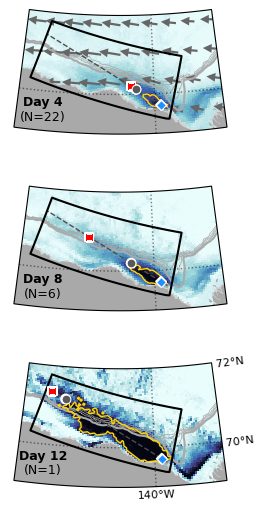

In [178]:
from matplotlib.ticker import FixedLocator

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range_small = (-150, -135)
lat_range_small = (69, 72)


wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]


# grab box border
clip_path_small = fn.create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(3,1,figsize=(4,6.5), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs):#.ravel()):
    
    ax.patch.set_facecolor('lightgray')

    ax.set_boundary(clip_path_small, transform=proj)
    ax.set_extent([lon_range_small[0], lon_range_small[1], 
                   lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
#     ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#                colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


    gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='dotted')
    gl.xlocator = FixedLocator([ -140])
    gl.ylocator = FixedLocator([70])
    gl.bottom_labels = False
    gl.right_labels = False

    if ax == axs.ravel()[-1]: 
        for lat in [70,72]:
            rot = -135-(-142.5)
            ax.text(-135, lat, f" {lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='center', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-140]:
            rot = lon-(-142.5)
            ax.text(lon, 68.95, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)
            
            
for n, key in enumerate(['4','8','12']):#list(across.keys())[1::2]):
    
    print(key)

    ax = axs.ravel()[n]
    
    ax.text(0.15,0.325,f'Day {key}', weight='bold', ha='center', va='bottom', transform=ax.transAxes)#, size=FS)
    ax.text(0.15,0.225,f'(N={len(across[key]['date'])})', ha='center', va='bottom', transform=ax.transAxes)#, size=FS)
    
    
    # bathymetry
    #-----------
    ax.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=1, transform=ccrs.PlateCarree())
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])
    
    # Open water frequency
    #---------------------
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'], zorder=0)
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#               vmin=0, vmax=50, cmap=cmocean.cm.dense, transform=dsic['proj'], zorder=0)
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 100*poly_maps[key]/total_maps[key],#100*map_sic[key]['open_freq'], 
              levels=[50], colors=['gold'], transform=dsic['proj'], zorder=99)

    # dashed line
    #------------
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    # markers
    #------------
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ 'dodgerblue', 'r', [0.35]*3], 
                                       [ 'white', 'white', 'white'], 
                                       ['D','s', 'o'], [25, 35, 40], [0.75,0.75,0.75]):
    
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=1.5, zorder=101)
    
    
# atmosphere
#-----------
for ax, key in zip(axs[:], [ '4', '8', '12']):

    print(key)
    
    # sea level press
    #----------------
#     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#                        era_map[key]['msl'][::sp,::sp]/100, 
#                        vmin=1012,vmax=1028, 
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
#     mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
#                        era_map[key]['msl'].mean('time')/100, 
#                        vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

    # winds
    #----------------
    longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
    u1 = era_map[key]['u10'].mean('time').values
    v1 = era_map[key]['v10'].mean('time').values
    U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
    sp1, sp2 = 3,6
    Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
                  U[::sp1,::sp2], V[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=0.0002, width=0.01, headwidth=4,headlength=4, headaxislength=4, 
                  color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    
ax = axs[0]
ax.text(0.975,1.025, f'c', weight='bold', 
            ha='right', va='bottom', size=FS+2, transform=ax.transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.0125, cb_length_fraction=[0.7, 1.05], cb_pad=0.015, cb_ticks=[0,100], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad=5,#-10, 
                     cb_label_placement='bottom', cb_tick_placement='top', tick_kwargs={'pad':0.1, 'length':2},#, 'length':0, 'labelsize':40, 'length':0.1, 'width':4}, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-1], loc=(0.05, -0.1), steps=[100,200,300],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)


plt.subplots_adjust(hspace=-0.05, )
    
SAVE(fig, '/Users/mackenziejewell/Desktop/map_panels.png')

In [ ]:
        

#     endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
#     ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
#                s=ms, marker=marker, facecolor='None', edgecolor='white',lw=2.5, zorder=101)
    
# axs[2].text(0.975,1.05, f'c', weight='bold', 
#                 ha='right', va='bottom', size=FS+2, transform=axs[2].transAxes)

# for aa, ax in enumerate(axs):
#     ax.text(0.975,0.95, f'{chr(aa+97)}', weight='bold', 
#                 ha='right', va='top', transform=ax.transAxes)
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], poly_maps[key]/total_maps[key], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
    

#     mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], 100*poly_maps[key]/total_maps[key], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
    
#     mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#           vmin=0, vmax=50, levels = np.arange(0,50,5), extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.6, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5, 0.75], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    

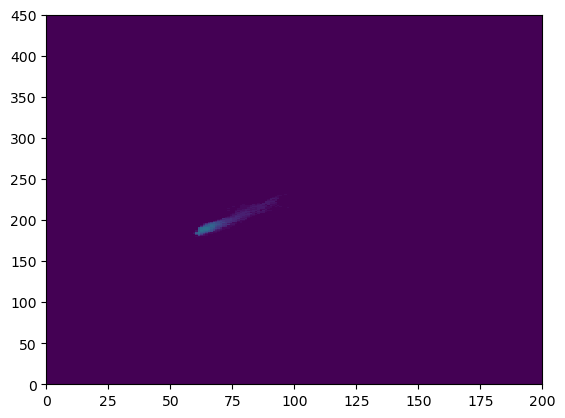

In [1364]:
plt.pcolormesh(100*poly_maps[key]/total_maps[key], vmin=0, vmax=2)

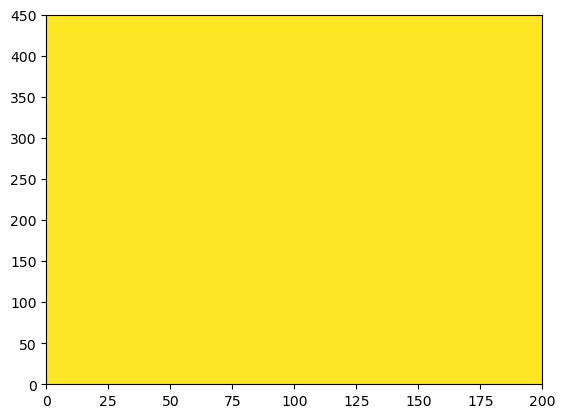

In [1376]:
plt.pcolormesh(poly_maps[key], vmin=0, vmax=19)
plt.pcolormesh(total_maps[key], vmin=0, vmax=200)
# /total_maps[key]

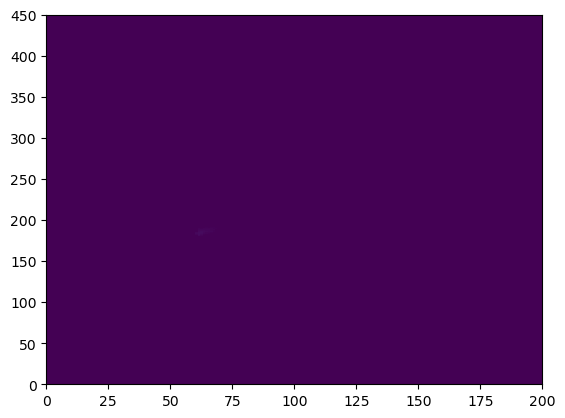

In [1372]:
plt.pcolormesh(poly_maps[key]/total_maps[key], vmin=0, vmax=1)

In [238]:
poly_maps = {}
for key in across.keys():
    poly_maps[key] = np.zeros_like(dsic['xx'])
    
total_maps = {}
for key in across.keys():
    total_maps[key] = np.zeros_like(dsic['xx'])
    
for key in ['4','8','12']:#list(across.keys())[1::2]:
    
    print(key)
    
    for cdate in across[key]['date']:
    
        YEAR = int(cdate.split('-')[0])
        MONTH = int(cdate.split('-')[1])
        if MONTH == 12:
            YEAR+=1

        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{YEAR}_sic10_v7.6_radius25km.nc') as ds2:

            xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
            yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

            total_maps[key] += 1
            
            for xv, yv in zip(xval, yval):

                dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
                poly_maps[key][np.where(dist == 0)] += 1

4
8
12


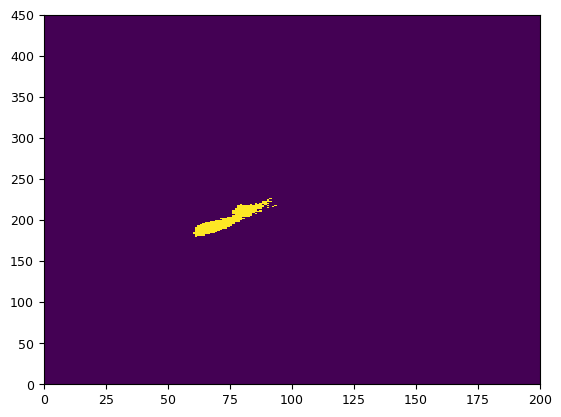

In [240]:
key = '12'
plt.pcolormesh(poly_maps[key]/total_maps[key])


In [ ]:
cdate.split('-')[0]

In [391]:
cdate.split('-')[0]

'2002'

In [381]:
ds2 = xr.open_dataset('../data/polynya_size/daily_polynya_2003_sic10_v7.4_radius25km.nc')


cdate = across[key]['date'][0]

xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

In [382]:
pol_counts = np.zeros_like(dsic['xx'])

for xv, yv in zip(xval, yval):
    
    dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
    
    pol_counts[np.where(dist == 0)] = 1

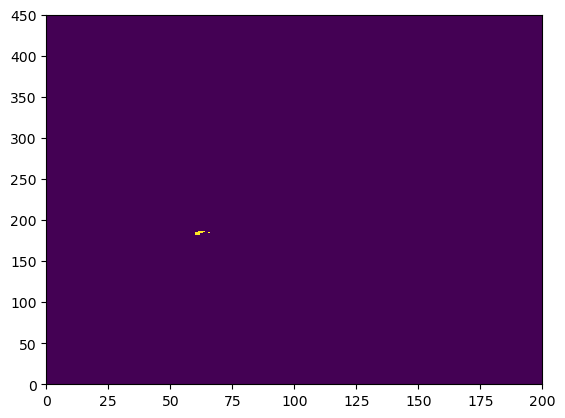

In [383]:
plt.pcolormesh(pol_counts)

In [289]:
key

'1'

In [292]:
np.array(list(across.keys()))

array(['$t_{i}$\n-2', '$t_{i}$\n-1', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10+', '$t_{f}$\n+1', '$t_{f}$\n+2'], dtype='<U10')

In [ ]:


def plot_angles(ax, X, cond, clip):
    label_nums(ax, X, np.sum(cond), clip)
    plot_dist(ax, X-0.15, *angle_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,361,7.5), yscale=1)
    plot_dist(ax, X+0.15, *angle_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,361,7.5), yscale=1)
    
#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
        
def plot_temps(ax, X, cond, clip):
    plot_dist(ax, X, *temp_distribution(df_base, cond), clip, bins = np.arange(-40,0,2), yscale=1)

def plot_msls(ax, X, cond, clip):
    plot_dist(ax, X, *msl_distribution(df_base, cond), clip, bins = np.arange(980,1060,4), yscale=1)
    
def plot_speeds(ax, X, cond, clip):
    plot_dist(ax, X-0.15, *speed_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,20,1), yscale=1)
    plot_dist(ax, X+0.15, *speed_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,40,2), yscale=0.5)    

#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
    
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1, scale = 5, show_mode = False):
    
    h = plotter.quick_hist(y, bin_edges=bins)
    
    if show_mode == True:
        ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
    else:
        ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
        
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   
    
#     ax.barh(h['centers'], scale*h['prob'], height=h['w'], left= X - scale*h['prob']/2, align='center', 
#             color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)
    

def plot_point(ax, X, y, Y, color, bg_color):
    ax.scatter(X, Y, c=color, clip_on=False)
    ax.scatter(np.linspace(X-0.05,X+0.05, len(y)), y, c=bg_color, s=1, zorder=-1, clip_on=False)

    
def size_distribution(df, cond):

    all_sizes = df['extent'][cond]/1000
    mean_size = np.nanmean(all_sizes)
    print(mean_size)
    color = 'k'
    bg_color = 'gray'

    return all_sizes, mean_size, color, bg_color


def msl_distribution(df, cond):

    all_ = df['msl'][cond]/100
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color

def temp_distribution(df, cond):

    all_ = df['t2m'][cond]
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color


def speed_distribution(df, cond, group):
    
    if group == 'atm':
        all_speeds = df['s10'][cond]
        mean_speed = np.nanmean(all_speeds)
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        all_speeds = df['si'][cond] #* units('cm/s').to('km/day').magnitude
        mean_speed = np.nanmean(all_speeds)
        color = 'r'
        bg_color = 'lightcoral'

    return all_speeds, mean_speed, color, bg_color

def angle_distribution(df, cond, group):

    if group == 'atm':
        U = df['u10'][cond]
        V = df['v10'][cond]
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        U = df['ui'][cond]
        V = df['vi'][cond]
        color = 'r'
        bg_color = 'lightcoral'

    all_angles = np.array([vectors.vector_angle(u,v).magnitude for u,v in zip(U,V)])
    mean_angle = vectors.vector_angle(np.nanmean(U), np.nanmean(V)).magnitude
    
    if mean_angle < 0:
        mean_angle+=360
    all_angles[all_angles<0] += 360

    return all_angles, mean_angle, color, bg_color

def label_nums(ax, x, N, clip):
    ax.text(x, -10, N, ha='center',va='bottom', size=5, clip_on=clip)
    
    